<a href="https://colab.research.google.com/github/AmulyaMat/Cell-Classification-Machine-Learning/blob/main/CellClassfication_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Objectives:

*   Construct machine learning and deep learning models to classify different cells (hMSCs and osteocytes) based on acquired Raman Spectra data
*   Using trained mode, determine cell viability of Pyrogallol-coated hMSCs
*   Determine the minimal sample size (training data) required to achieve stable accuracy trend from the best model



Code last updated in March 2023

In [ ]:
#@title
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from scipy.signal import savgol_filter
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.signal import find_peaks


from sklearn import preprocessing as pp
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier #new model 1
from xgboost import XGBClassifier #new model 2
from sklearn.preprocessing import LabelEncoder #for new model 2

from sklearn.model_selection import learning_curve #for learning curves


from pathlib import Path

from tkinter import Tk, filedialog

# Futures
# from __future__ import print_function
# […]

# Built-in/Generic Imports
import os
import argparse, glob, sys

# Code Information
__author__ = 'Derrick Yong (edit v2 & 3); Lydia Chong (edit v4, original v1); Elizabeth Lee (fork v2)'
__copyright__ = 'Copyright 2019-2022, Raman Spectroscopy for Cell Logistics (SIMTech x NTU x SMART)'
__credits__ = ['Zhang Jingyi (FYP 19/20), Darylene Tay (FYP 20/21)']
__license__ = '{license}'
__version__ = '4.0.0'
__maintainer__ = 'Derrick Yong; Lydia Chong; Elizabeth Lee'
__email__ = 'derrick-yong@ibb.a-star.edu.sg; LYDI0013@e.ntu.edu.sg; elizabeth.lee@smart.mit.edu'
__status__ = 'WIP'


#%% Initialisation

#--- Data processing parameters
#Truncation
RamanShift_start = 950 #370 950
RamanShift_end = 1800 #1200 1800

#Comsic ray spike threshold
thresholdNum = 7

#Savitzky-Golay filter
SGFilter_windowLength = 11 #default:51 #default: 21 for hMSC data
SGFilter_polyOrder = 3 #default:3

#Baseline correction
Baseline_lam = 1000 #default:1000; powder:100000
Baseline_p = 0.005 #default:0.005

#Multiple graph plotting
Offset = 0.16

#Peak search
Peak_prominence = 0.004

#PCA
principalComponentsNum = 5

#Spectral Clustering
spectClust_NclustersNum = 2
spectClust_NneighborsNum = 7

#--- Select folder

root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.

filePath = filedialog.askdirectory() # Returns opened path as str
fileList = glob.glob(filePath + '/*.asc') #txt


#%% Functions

def main():

    #--- Loop through files in folder
    for nFile in range(len(fileList)):

        print(str(str(nFile+1) + ' out of ' + str(len(fileList))))

        #Load file and organise label
        fileFull, fileFullSplit, dataRaw, backgroundData = fileload(nFile)
        fileName = fileFullSplit[-1]
        fileNameSplit = fileName.split(' ')
        fileLoc = fileFullSplit[-2]
        #dataLabel = str(fileNameSplit[0] + '-' + fileNameSplit[1] + '-' + fileNameSplit[3])
        #dataLabel = fileNameSplit[-1]
        dataLabel = fileNameSplit[0] #+ '-' + fileNameSplit[1] #fileNameSplit[0] + '-' + fileNameSplit[1] fileName[:-4]
        print(dataLabel)

        #Process data
        RamanShift, dataIntensity_SigProc = sigproc(dataRaw, backgroundData)

        #Plot multiple plot with offset
        plt.plot(RamanShift, dataIntensity_SigProc + Offset*nFile, label=dataLabel)
        #For horizontal legend
        #plt.legend(loc='upper left', ncol = nFile+1) #mode = "expand"
        #For vertical legend
        #plt.legend(loc='upper right')
        plt.xlim(RamanShift_start, RamanShift_end)
        plt.xlabel("Raman Shift (cm-1)", fontsize=15)
        plt.ylabel("Normalized Intensity", fontsize=15)
        #plt.title(dataLabel, fontsize=10)

        #Identify peaks
        indexes, _ = find_peaks(dataIntensity_SigProc.flatten(), prominence=Peak_prominence)

        indNum = 0
        for j in indexes:
            #plt.plot(RamanShift[j], dataIntensity_SigProc[j],'ro')

            dataIntensity_SigProc_peaksTemp = np.array([np.around(RamanShift[j]), dataIntensity_SigProc[j]])
            dataIntensity_SigProc_peaksTemp = dataIntensity_SigProc_peaksTemp.reshape(1,2)
            if indNum == 0:
                dataIntensity_SigProc_peaksArrayTemp = dataIntensity_SigProc_peaksTemp
            else:
                dataIntensity_SigProc_peaksArrayTemp = np.concatenate((dataIntensity_SigProc_peaksArrayTemp,dataIntensity_SigProc_peaksTemp))

            indNum += 1

        #plt.savefig(str(fileFull[:-4] + '-SigProc' + '.png'))
        #plt.show()
        #plt.clf()

        #Compile processed data and identified peaks
        dataIntensity_SigProc_peaksArrayTemp_df = pd.DataFrame(dataIntensity_SigProc_peaksArrayTemp,columns=['Raman Shift',fileName])

        if nFile == 0:
            dataIntensity_SigProc_peaks_df = dataIntensity_SigProc_peaksArrayTemp_df
            dataIntensity_SigProc_df = pd.DataFrame(np.concatenate((RamanShift,dataIntensity_SigProc),axis=1),columns=['Raman Shift',fileName])
            dataLabels = [dataLabel]
        else:
            dataIntensity_SigProc_peaks_df = pd.merge(dataIntensity_SigProc_peaks_df,dataIntensity_SigProc_peaksArrayTemp_df,how='outer',on=['Raman Shift'],sort='True')
            dataIntensity_SigProc_df[fileName]=dataIntensity_SigProc
            dataLabels.append(dataLabel)

    dataLabels_df = pd.DataFrame(dataLabels, columns=['Label'])

    # Export processed spectra and peaks
    #dataIntensity_SigProc_df.to_excel(str(os.path.sep.join(fileFullSplit[0:-1]) + os.path.sep + fileLoc + '-SigProc-Compiled' + '.xls'))
    #dataIntensity_SigProc_peaks_df.to_excel(str(os.path.sep.join(fileFullSplit[0:-1]) + os.path.sep + fileLoc + '-SigProc-Peaks-Compiled' + '.xls'))


    # Plot Raman spectra with standard dev

    #dataIntensity_SigProc_combined = pd.concat([dataIntensity_SigProc_df.iloc[:,1],dataIntensity_SigProc_df.iloc[:,7:11]],axis=1)
    #dataIntensity_SigProc_np = np.array(dataIntensity_SigProc_combined)
    #dataIntensity_SigProc_np = np.array(dataIntensity_SigProc_df.iloc[:,1:6])
    #print(dataIntensity_SigProc_np)
    #dataIntensity_SigProc_mean = np.mean(dataIntensity_SigProc_np, axis=1)
    #dataIntensity_SigProc_std = np.std(dataIntensity_SigProc_np, axis=1)
    #print(dataIntensity_SigProc_mean)
    #print(dataIntensity_SigProc_std)

    #dataIntensity_SigProc_np_SERS = np.array(dataIntensity_SigProc_df.iloc[:,6:11])
    #dataIntensity_SigProc_mean_SERS = np.mean(dataIntensity_SigProc_np_SERS, axis=1)


    RamanShift_noheader = dataIntensity_SigProc_df.iloc[:,0]
    #print(RamanShift_noheader)
    dataIntensity_SigProc_np = np.array(dataIntensity_SigProc_df.iloc[:,1:])
    dataIntensity_SigProc_mean = np.mean(dataIntensity_SigProc_np, axis=1)
    dataIntensity_SigProc_std = np.std(dataIntensity_SigProc_np, axis=1)
    #print(dataIntensity_SigProc_mean)
    #print(dataIntensity_SigProc_std)

    # Create new plot for mean Raman spectra
    plt.figure()
    plt.fill_between (RamanShift_noheader, dataIntensity_SigProc_mean+dataIntensity_SigProc_std, dataIntensity_SigProc_mean-dataIntensity_SigProc_std, color ='lightblue') #mistyrose
    plt.plot (RamanShift_noheader,dataIntensity_SigProc_mean,color='blue') #maroon
    plt.xlim(RamanShift_start, RamanShift_end)
    #plt.fill_between (PG1x, PG1y+PG1error, PG1y-PG1error, color ='coral', alpha = 0.5)
    #plt.plot (PG1x,PG1y,color='coral')
    #plt.fill_between (Barex, Barey+Bareerror, Barey-Bareerror, color ='cornflowerblue', alpha = 0.5)
    #plt.plot (Barex,Barey,color='royalblue')

    #ax = plt.gca()
    #ax.axes.yaxis.set_ticks([]) # Hide y axis ticks
    #plt.axvspan(992,1022,facecolor='g', alpha=0.2, label=['Proteins'])
    #plt.axvspan(1626,1686,facecolor='g', alpha=0.2)
    #plt.axvspan(1056,1116,facecolor='y', alpha=0.2, label=['Lipids'])
    #plt.axvspan(1227,1287,facecolor='y', alpha=0.2)
    #plt.legend(["Lipids"])


    plt.xlabel("Raman Shift (cm-1)", fontsize=15)
    plt.ylabel("Normalized Intensity", fontsize=15)

    #plt.plot(RamanShift, dataIntensity_SigProc_mean, 'b-')
    #plt.plot(RamanShift, dataIntensity_SigProc_mean_SERS, 'r-')
    #plt.legend(['GS','SERS'])



    figureName = (fileFull[0:-4] + '.png')
    plt.savefig(os.path.join(filePath,figureName),transparent=True)
    plt.show()


    #--- PCA

    # Standardizing features before performing PCA
    scaler = StandardScaler()
    dataIntensity_SigProg_Scaled = scaler.fit_transform(dataIntensity_SigProc_df.iloc[:,1:].T) #fit and transform data with scaler
    dataIntensity_SigProg_Scaled_df = pd.DataFrame(data = dataIntensity_SigProg_Scaled)

    # Perform PCA on processed data
    pca = PCA(n_components=principalComponentsNum)
    principalComponentNames = ['PC' + str(n) for n in range(1,principalComponentsNum+1)]

    dataIntensity_SigProg_Scaled_PC = pca.fit_transform(dataIntensity_SigProg_Scaled)
    dataIntensity_SigProg_Scaled_PC_df = pd.DataFrame(data = dataIntensity_SigProg_Scaled_PC, columns = principalComponentNames)

    dataIntensity_SigProc_Scaled_PC_df_forExport = pd.concat([dataIntensity_SigProg_Scaled_PC_df, dataLabels_df], axis = 1)
    dataIntensity_SigProc_Scaled_PC_df_forExport.to_excel(str(os.path.sep.join(fileFullSplit[0:-1]) + os.path.sep + '-SigProc-PCs' + '.xls'))

    # Create color dictionary and vector
    labelColorDict = {label:idx for idx,label in enumerate(np.unique(dataLabels))}
    colorVec = [labelColorDict[label] for label in dataLabels]

    # Plot PCA-ed data with labels (PC2 vs PC1)
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100), fontsize = 25)
    ax.set_ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100), fontsize = 25)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

    scatterPC1PC2 = ax.scatter(dataIntensity_SigProg_Scaled_PC[:,0], dataIntensity_SigProg_Scaled_PC[:,1], c=colorVec, cmap='Spectral', alpha=0.5)
    scatterPC1PC2_handles, scatterPC1PC2_labels = scatterPC1PC2.legend_elements(prop="colors", alpha=0.5)
    scatterPC1PC2_legend = ax.legend(scatterPC1PC2_handles, labelColorDict.keys(),loc='upper right', title='Type')
    ax.add_artist(scatterPC1PC2_legend)

    # Plot PCA loadings
    plt.figure()
    plt.plot(RamanShift,pca.components_[1])
    # plt.show()


    #--- Unsupervised Learning

    #Spectral Clustering
    #dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_specClust = spectral_clustering(dataIntensity_SigProg_Scaled_PC)


    #specClustPC1PC2 = ax.scatter(dataIntensity_SigProg_Scaled_PC[:,0], dataIntensity_SigProg_Scaled_PC[:,1], c=dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_specClust.labels_+1,s=200, alpha=0.2)
    #specClustPC1PC2_handles, specClustPC1PC2_labels = specClustPC1PC2.legend_elements(prop="colors", alpha=0.2)
    #specClustPC1PC2_legend = ax.legend(specClustPC1PC2_handles, specClustPC1PC2_labels,loc='upper left', title='Spectral Cluster')
    #ax.add_artist(specClustPC1PC2_legend)
    #plt.show()

    #--- Supervised Learning

    #If want to split dataset into random train and test subsets
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
    skf.get_n_splits(dataIntensity_SigProg_Scaled_df,dataLabels_df)
    for train_index, test_index in skf.split(dataIntensity_SigProg_Scaled,dataLabels_df):
        print("TRAIN:", train_index, "TEST:", test_index)
        Sample_train, Sample_test = dataIntensity_SigProg_Scaled_df.iloc[train_index], dataIntensity_SigProg_Scaled_df.iloc[test_index]
        label_train, label_test = dataLabels_df.iloc[train_index], dataLabels_df.iloc[test_index]
    #Sample_train, Sample_test, Label_train, Label_test = train_test_split(dataIntensity_SigProg_Scaled,dataLabels_df, test_size=0.20)
    ##Specify train, test dataset with their corresponding labels
    print(label_train)
    print(label_test)

    traindataIntensity_SigProg_Scaled_PC = pca.fit_transform(Sample_train)
    traindataIntensity_SigProg_Scaled_PCdf = pd.DataFrame(data = traindataIntensity_SigProg_Scaled_PC, columns = principalComponentNames)

    testdataIntensity_SigProg_Scaled_PC = pca.transform(Sample_test)
    testdataIntensity_SigProg_Scaled_PCdf = pd.DataFrame(data = testdataIntensity_SigProg_Scaled_PC, columns = principalComponentNames)

    data_train = traindataIntensity_SigProg_Scaled_PCdf
    data_test = testdataIntensity_SigProg_Scaled_PCdf


    #Label_train = trainLabels
    #TrueLabel_test = pd.DataFrame(np.repeat(['Live','Dead'],[30,30],axis=None))

    #Perform k-fold cross validation on training data to evaluate model performance (potential overfitting issue)
    #kf = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)  # Define the split // Stratified KFold retains % of samples for each class
    #for train_index, val_index in kf.split(Sample_train, Label_train):
    #        data_train = Sample_train.iloc[train_index]
    #        label_train = Label_train.iloc[train_index]
    #        data_val = Sample_train.iloc[val_index]
    #        label_val = Label_train.iloc[val_index]

    #data_test = Sample_test

    #KNN
    #KNN = KNeighborsClassifier()
    #k_range = list(range(1, 20))
    #param_grid = dict(n_neighbors=k_range)
    #gscv = GridSearchCV(KNN, param_grid, cv=5)
    #gscv.fit(data_train,label_train)
    #gscv.best_params_
    #print(gscv.best_params_)
    #KNN_optimal = gscv.best_estimator_
    #KNN_optimal.fit(data_train,label_train)






    KNN = KNeighborsClassifier(n_neighbors=5)
    KNN.fit(data_train,label_train)
    PredictLabel_KNN = KNN.predict(data_test)
    print(PredictLabel_KNN)
    cmKNN = confusion_matrix(label_test, PredictLabel_KNN, normalize='all')
    #tn, fp, fn, tp = confusion_matrix(Label_test, Label_predict,normalize='all').ravel()

    plot_confusion_matrix(cmKNN,Label_classes=np.unique(label_train),title='Confusion Matrix-KNN')
    #print(classification_report(Label_test, Label_predict))

    #learning curve
    train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(), data_train, label_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)


    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()








    #NB
    GNB = GaussianNB()
    GNB.fit(data_train,label_train)
    PredictLabel_GNB = GNB.predict(data_test)
    cmGNB = confusion_matrix(label_test, PredictLabel_GNB, normalize='all')
    plot_confusion_matrix(cmGNB,Label_classes=np.unique(label_train),title='Confusion Matrix-NB')

    #SVM
    LSVM = svm.SVC(kernel='linear')
    LSVM.fit(data_train, label_train)
    PredictLabel_LSVM = LSVM.predict(data_test)
    cmLSVM = confusion_matrix(label_test, PredictLabel_LSVM, normalize='all')
    #LSVM = svm.LinearSVC()
    #LSVM.fit(Sample_train, Label_train)
    #Label_predict_LSVM = LSVM.predict(Sample_test)
    #cmLSVM = confusion_matrix(Label_test, Label_predict_LSVM, normalize='all')

    SVM = svm.SVC(kernel='poly',degree=3) #kernel='rbf'
    SVM.fit(data_train, label_train)
    PredictLabel_SVM = SVM.predict(data_test)
    cmSVM = confusion_matrix(label_test, PredictLabel_SVM, normalize='all')

    plot_confusion_matrix(cmLSVM,Label_classes=np.unique(label_train),title='Confusion Matrix-LSVM')
    plot_confusion_matrix(cmSVM,Label_classes=np.unique(label_train),title='Confusion Matrix-SVM')


    #RF - new model 1
    rf=RandomForestClassifier(n_estimators=1000, random_state = 42)
    rf.fit(data_train,label_train.values.ravel())
    PredictLabel_RF= rf.predict(data_test)
    cmRF = confusion_matrix(label_test, PredictLabel_RF, normalize='all')
    plot_confusion_matrix(cmRF,Label_classes=np.unique(label_train),title='Confusion Matrix-RF')

    #XG BOOST - new model 2
    le = LabelEncoder()  #converting 'dead' &  'live' to 0 and 1 for model to work
    label_train_le = le.fit_transform(label_train)
    label_test_le = le.fit_transform(label_test)

    XGB = XGBClassifier()
    XGB.fit(data_train, label_train_le)

    PredictLabel_XGB = XGB.predict(data_test)
    PredictLabel_XGB_le = le.fit_transform(PredictLabel_XGB)

    cmXGB = confusion_matrix(label_test_le, PredictLabel_XGB_le, normalize='all')
    plot_confusion_matrix(cmXGB,Label_classes=np.unique(label_train_le),title='Confusion Matrix-XGB')






    #-- Evaluate f1 score for various trained model on validation dataset

    #KNN
    #print(f"KNN's f1-score on the validation set: {f1_score(label_val, KNN.predict(data_val), pos_label = 'Live')}")
    cv_scores_KNN = cross_val_score(KNN, np.array(data_train), np.array(label_train).ravel(), cv=5)
    print((np.mean(cv_scores_KNN)))

    #GNB
    #print(f"NB's f1-score on the validation set: {f1_score(label_val, GNB.predict(data_val), pos_label = 'Live')}")
    cv_scores_GNB = cross_val_score(GNB, np.array(data_train), np.array(label_train).ravel(), cv=5)
    print((np.mean(cv_scores_GNB)))

    #SVM
    #print(f"LSVM's f1-score on the validation set: {f1_score(label_val, LSVM.predict(data_val), pos_label = 'Live')}")
    #print(f"SVM's f1-score on the validation set: {f1_score(label_val, SVM.predict(data_val), pos_label = 'Live')}")
    cv_scores_LSVM = cross_val_score(LSVM, np.array(data_train), np.array(label_train).ravel(), cv=5)
    print((np.mean(cv_scores_LSVM)))
    cv_scores_SVM = cross_val_score(SVM, np.array(data_train), np.array(label_train).ravel(), cv=5)
    print((np.mean(cv_scores_SVM)))

    #RF
    cv_scores_RF = cross_val_score(rf, np.array(data_train), np.array(label_train).ravel(), cv=5)
    print((np.mean(cv_scores_RF)))

    #XG Booster
    cv_scores_XGB = cross_val_score(XGB, np.array(data_train), np.array(label_train_le).ravel(), cv=5)
    print((np.mean(cv_scores_XGB)))








#--- File Loading
def fileload(nFile):
    fileFull = fileList[nFile]
    fileFullSplit = fileFull.split(os.path.sep)
    fileBackground = "media-SigProc-Mean.xls"
    fileBackgroundLoc = os.path.join(filePath, fileBackground)

    dataRaw = pd.read_csv(fileFull, sep=',', header = None,skiprows=33) #\t #skiprows = 33
    #dataRaw_arr = np.loadtxt(fileFull , skiprows = 38)
    #dataRaw = pd.DataFrame(dataRaw_arr)

    backgroundData = pd.read_excel(fileBackgroundLoc, header = None)

    # dataRaw_df = pd.DataFrame(dataRaw)
    # dataRaw_array = np.array(dataRaw_df)

    return fileFull, fileFullSplit, dataRaw, backgroundData


#--- Data Processing
def sigproc(dataRaw,backgroundData):

    dataRawRamanShift = dataRaw.iloc[:,0]
    dataRawIntensity = dataRaw.iloc[:,1]

    # Truncation
    dataRawRamanShift_startInd = dataRawRamanShift[dataRawRamanShift < RamanShift_start].idxmax()
    dataRawRamanShift_endInd = dataRawRamanShift[dataRawRamanShift > RamanShift_end].idxmin()

    RamanShift = np.array(dataRawRamanShift.iloc[dataRawRamanShift_startInd : dataRawRamanShift_endInd-1])    # Index selection of Raman shift span
    RamanShift = RamanShift.reshape(len(RamanShift),1)

    dataIntensity = np.array(dataRawIntensity.iloc[dataRawRamanShift_startInd : dataRawRamanShift_endInd-1])   # Index selection of corresponding dataIntensity values

    # Removing cosmic ray spikes before smoothing
    dataIntensity_spikeRemove = fixer(dataIntensity,m=3)
    #dataIntensity_spikeRemove = dataIntensity

    # Smoothing with Savitzky-Golay filter for noise removal
    dataIntensity_spikeRemove_SGFilter = savgol_filter(dataIntensity_spikeRemove, window_length=SGFilter_windowLength, polyorder=SGFilter_polyOrder, axis=0)
    dataIntensity_spikeRemove_SGFilter_df = pd.DataFrame(dataIntensity_spikeRemove_SGFilter)

    # Baseline correction
    baselineData = baseline_correction((dataIntensity_spikeRemove_SGFilter_df).T, lam=Baseline_lam, p=Baseline_p).T #baselinefit and normalization need to be done with each sample representing each row
    dataIntensity_spikeRemove_SGFilter_baselineSub = dataIntensity_spikeRemove_SGFilter_df - baselineData

    # Background subtraction
    dataIntensity_spikeRemove_SGFilter_baselineSub_backgroundSub = dataIntensity_spikeRemove_SGFilter_baselineSub - backgroundData

    # Vector normalization
    dataIntensity_spikeRemove_SGFilter_baselineSub_backgroundSub_vecNorm = (vector_normalization(dataIntensity_spikeRemove_SGFilter_baselineSub_backgroundSub.T)).T

    return RamanShift, dataIntensity_spikeRemove_SGFilter_baselineSub_backgroundSub_vecNorm

def modified_z_score(intensity):
     median_int = np.median(intensity)
     mad_int = np.median([np.abs(intensity - median_int)])
     modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
     return modified_z_scores

def fixer(y,m):
    threshold = thresholdNum # binarization threshold  #default=7
    spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
    y_out = y.copy()

    for i in np.arange(len(spikes)):
        if spikes[i] != 0: # If we have an spike in position i
            w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
            w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
            y_out[i] = np.mean(y[w2])
    return y_out

def baseline_correction(raman_spectra, lam, p, niter=10):  # lam = 1000, p = 0.005
    # According to "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
    # https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data
    number_of_spectra = raman_spectra.index.size
    baselineData = pd.DataFrame(np.zeros((len(raman_spectra.index), len(raman_spectra.columns))))

    for ii in np.arange(number_of_spectra):
        curr_dataset = raman_spectra.iloc[ii, :]

        # code for the fitting procedure
        L = len(curr_dataset)
        w = np.ones(L)
        D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))

        for jj in range(int(niter)):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w * curr_dataset.astype(np.float64))
            w = p * (curr_dataset > z) + (1 - p) * (curr_dataset < z)
        # end of fitting procedure

        baselineData.iloc[ii, :] = z
    return baselineData

def vector_normalization(vector):
    dataIntensity_SGFilter_baselineSub_vecNorm = pp.normalize(vector, norm="l2", axis=1)
    return dataIntensity_SGFilter_baselineSub_vecNorm

def spectral_clustering(dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_PC):
    specClust = SpectralClustering(n_clusters=2, eigen_solver=None, random_state=0
                                      , n_init=10, gamma=1.0, affinity='nearest_neighbors'
                                      , n_neighbors=7, assign_labels='kmeans')
    dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_specClust = specClust.fit(dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_PC)
    return dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_specClust

def plot_confusion_matrix(cm,Label_classes,title):

        cmap = plt.get_cmap('Blues') #cmap=plt.cm.Blues

        plt.figure(figsize=(8,6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title,fontsize=25)

        cbar = plt.colorbar()
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(15)

        tick_marks = np.arange(len(Label_classes))
        plt.xticks(tick_marks, Label_classes, fontsize=20) #rotation=45
        plt.yticks(tick_marks, Label_classes,fontsize=20)

        accuracy = np.trace(cm)/np.sum(cm) #same as using accuracy_score(Label_test, Label_predict) #diagonal summation: tn+tp/total
        precision = cm[1,1]/np.sum(cm,axis=0)[1] #tp/tp+fp
        recall = cm[1,1]/np.sum(cm,axis=1)[1] #tp/tp+fn (sensitivity)
        specificity = cm[0,0]/np.sum(cm,axis=1)[0]  #tn/tn+fp
        f1Score = (2*precision*recall)/(precision + recall)


        threshold = cm.max() / 1.5
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j,i, "{:0.3f}".format(cm[i, j]), #adding text to x,y coordinate
                         horizontalalignment="center",
                         color="white" if cm[i, j] > threshold else "black",fontsize=22)

        plt.tight_layout()
        plt.ylabel('True label',fontsize=22)
        plt.xlabel('Predicted label \n Accuracy= {:.1%}; F1-score= {:.1%}'.format(accuracy, f1Score),fontsize=22)

        plt.show()


if __name__ == '__main__': main()







## **1. Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from scipy.signal import savgol_filter
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.signal import find_peaks

from sklearn import preprocessing as pp
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier # new model 1
from xgboost import XGBClassifier # new model 2
from sklearn.preprocessing import LabelEncoder # for new model 2

from sklearn.model_selection import learning_curve # for learning curves
from yellowbrick.model_selection import LearningCurve # for learning curve

from pathlib import Path

from tkinter import Tk, filedialog

# Futures
# from __future__ import print_function
# […]

# Built-in/Generic Imports
import os
import argparse, glob, sys

# Code Information
__author__ = 'Derrick Yong (edit v2 & 3); Lydia Chong (edit v4, original v1); Elizabeth Lee (fork v2)'
__copyright__ = 'Copyright 2019-2022, Raman Spectroscopy for Cell Logistics (SIMTech x NTU x SMART)'
__credits__ = ['Zhang Jingyi (FYP 19/20), Darylene Tay (FYP 20/21)']
__license__ = '{license}'
__version__ = '4.0.0'
__maintainer__ = 'Derrick Yong; Lydia Chong; Elizabeth Lee'
__email__ = 'derrick-yong@ibb.a-star.edu.sg; LYDI0013@e.ntu.edu.sg; elizabeth.lee@smart.mit.edu'
__status__ = 'WIP'

## **2. Initialise constants for Signal Processing**

In [ ]:
#%% Initialisation

#--- Data processing parameters
#Truncation
RamanShift_start = 950 #370 950
RamanShift_end = 1800 #1200 1800

#Comsic ray spike threshold
thresholdNum = 7

#Savitzky-Golay filter
SGFilter_windowLength = 11 #default:51 #default: 21 for hMSC data
SGFilter_polyOrder = 3 #default:3

#Baseline correction
Baseline_lam = 1000 #default:1000; powder:100000
Baseline_p = 0.005 #default:0.005

#Multiple graph plotting
Offset = 0.16

#Peak search
Peak_prominence = 0.004

#PCA
principalComponentsNum = 5

#Spectral Clustering
spectClust_NclustersNum = 2
spectClust_NneighborsNum = 7

#--- Select folder

#root = Tk() # pointing root to Tk() to use it as Tk() in program.
#root.withdraw() # Hides small tkinter window.
#root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.

#filePath = filedialog.askdirectory() # Returns opened path as str
#fileList = glob.glob(filePath + '/*.asc') #txt

#filePath = "/content/drive/MyDrive/LiveDeadhMSC"
#filePath = "/content/drive/MyDrive/20221025_p7hMSC_2"
filePath = "/content/drive/MyDrive/One class cells"
#l = os.listdir(filePath)
fileList = glob.glob(filePath + '/*.asc') #txt



## **3. Define Functions**

In [ ]:
#@title
def fileload(nFile):
    fileFull = fileList[nFile]
    fileFullSplit = fileFull.split(os.path.sep)
    #fileBackground = "media-SigProc-Mean.xls"
    fileBackground = "-SigProc-Mean.xls"
    fileBackgroundLoc = os.path.join(filePath, fileBackground)

    #dataRaw = pd.read_csv(fileFull, sep=',', header = None,skiprows=33) #\t #skiprows = 33
    dataRaw = pd.read_csv(fileFull, sep='\t', header = None,skiprows=33) #\t #skiprows = 33 for 20221025 data
    #dataRaw_arr = np.loadtxt(fileFull , skiprows = 38)
    #dataRaw = pd.DataFrame(dataRaw_arr)

    backgroundData = pd.read_excel(fileBackgroundLoc, header = None)

    # dataRaw_df = pd.DataFrame(dataRaw)
    # dataRaw_array = np.array(dataRaw_df)

    return fileFull, fileFullSplit, dataRaw, backgroundData


def modified_z_score(intensity):
     median_int = np.median(intensity)
     mad_int = np.median([np.abs(intensity - median_int)])
     modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
     return modified_z_scores



def fixer(y,m):
    threshold = thresholdNum # binarization threshold  #default=7
    spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
    y_out = y.copy()

    for i in np.arange(len(spikes)):
        if spikes[i] != 0: # If we have an spike in position i
            w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
            w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
            y_out[i] = np.mean(y[w2])
    return y_out



def baseline_correction(raman_spectra, lam, p, niter=10):  # lam = 1000, p = 0.005
    # According to "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
    # https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data
    number_of_spectra = raman_spectra.index.size
    baselineData = pd.DataFrame(np.zeros((len(raman_spectra.index), len(raman_spectra.columns))))

    for ii in np.arange(number_of_spectra):
        curr_dataset = raman_spectra.iloc[ii, :]

        # code for the fitting procedure
        L = len(curr_dataset)
        w = np.ones(L)
        D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))

        for jj in range(int(niter)):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w * curr_dataset.astype(np.float64))
            w = p * (curr_dataset > z) + (1 - p) * (curr_dataset < z)
        # end of fitting procedure

        baselineData.iloc[ii, :] = z
    return baselineData



def vector_normalization(vector):
    dataIntensity_SGFilter_baselineSub_vecNorm = pp.normalize(vector, norm="l2", axis=1)
    return dataIntensity_SGFilter_baselineSub_vecNorm



def sigproc(dataRaw,backgroundData):

    dataRawRamanShift = dataRaw.iloc[:,0]
    dataRawIntensity = dataRaw.iloc[:,1]

    # Truncation
    dataRawRamanShift_startInd = dataRawRamanShift[dataRawRamanShift < RamanShift_start].idxmax()
    dataRawRamanShift_endInd = dataRawRamanShift[dataRawRamanShift > RamanShift_end].idxmin()

    RamanShift = np.array(dataRawRamanShift.iloc[dataRawRamanShift_startInd : dataRawRamanShift_endInd-1])    # Index selection of Raman shift span
    RamanShift = RamanShift.reshape(len(RamanShift),1)

    dataIntensity = np.array(dataRawIntensity.iloc[dataRawRamanShift_startInd : dataRawRamanShift_endInd-1])   # Index selection of corresponding dataIntensity values

    # Removing cosmic ray spikes before smoothing
    dataIntensity_spikeRemove = fixer(dataIntensity,m=3)
    #dataIntensity_spikeRemove = dataIntensity

    # Smoothing with Savitzky-Golay filter for noise removal
    dataIntensity_spikeRemove_SGFilter = savgol_filter(dataIntensity_spikeRemove, window_length=SGFilter_windowLength, polyorder=SGFilter_polyOrder, axis=0)
    dataIntensity_spikeRemove_SGFilter_df = pd.DataFrame(dataIntensity_spikeRemove_SGFilter)

    # Baseline correction
    baselineData = baseline_correction((dataIntensity_spikeRemove_SGFilter_df).T, lam=Baseline_lam, p=Baseline_p).T #baselinefit and normalization need to be done with each sample representing each row
    dataIntensity_spikeRemove_SGFilter_baselineSub = dataIntensity_spikeRemove_SGFilter_df - baselineData

    # Background subtraction
    dataIntensity_spikeRemove_SGFilter_baselineSub_backgroundSub = dataIntensity_spikeRemove_SGFilter_baselineSub - backgroundData

    # Vector normalization
    dataIntensity_spikeRemove_SGFilter_baselineSub_backgroundSub_vecNorm = (vector_normalization(dataIntensity_spikeRemove_SGFilter_baselineSub_backgroundSub.T)).T

    return RamanShift, dataIntensity_spikeRemove_SGFilter_baselineSub_backgroundSub_vecNorm



def spectral_clustering(dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_PC):
    specClust = SpectralClustering(n_clusters=2, eigen_solver=None, random_state=0
                                      , n_init=10, gamma=1.0, affinity='nearest_neighbors'
                                      , n_neighbors=7, assign_labels='kmeans')
    dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_specClust = specClust.fit(dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_PC)
    return dataIntensity_SGFilter_baselineSub_vecNorm_Scaled_specClust

def plot_confusion_matrix(cm,Label_classes,title):

        cmap = plt.get_cmap('Blues') #cmap=plt.cm.Blues

        plt.figure(figsize=(8,6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title,fontsize=25)

        cbar = plt.colorbar()
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(15)

        tick_marks = np.arange(len(Label_classes))
        plt.xticks(tick_marks, Label_classes, fontsize=20) #rotation=45
        plt.yticks(tick_marks, Label_classes,fontsize=20)

        accuracy = np.trace(cm)/np.sum(cm) #same as using accuracy_score(Label_test, Label_predict) #diagonal summation: tn+tp/total
        precision = cm[1,1]/np.sum(cm,axis=0)[1] #tp/tp+fp
        recall = cm[1,1]/np.sum(cm,axis=1)[1] #tp/tp+fn (sensitivity)
        specificity = cm[0,0]/np.sum(cm,axis=1)[0]  #tn/tn+fp
        f1Score = (2*precision*recall)/(precision + recall)


        threshold = cm.max() / 1.5
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j,i, "{:0.3f}".format(cm[i, j]), #adding text to x,y coordinate
                         horizontalalignment="center",
                         color="white" if cm[i, j] > threshold else "black",fontsize=22)

        plt.tight_layout()
        plt.ylabel('True label',fontsize=22)
        plt.xlabel('Predicted label \n Accuracy= {:.1%}; F1-score= {:.1%}'.format(accuracy, f1Score),fontsize=22)

        plt.show()

In [ ]:
def plot_model_performance (history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epoch = range(len(loss))

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epoch,loss,label='train_loss')
  plt.plot(epoch,val_loss,label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title("Loss graph")

  plt.subplot(1, 2, 2)
  plt.plot(epoch,acc,label='train_acc')
  plt.plot(epoch,val_acc,label='val_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(0, 1)
  plt.legend()
  plt.title("Accuracy graph")

## **4. Supervised Learning for untreated cell & DIFF cell classification**

### **4.1 Extracting files**

In [ ]:
pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 4.7 MB/s eta 0:00:00
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0


In [ ]:
file01 = "/content/drive/MyDrive/Untreated and DIFF cell classification/Diff and Untreated cells-RamanProcessed-Compiled.csv"

In [ ]:
Cells = pd.read_csv(file01)
Cells = Cells.iloc[:, 1:]
Cells

,0,1,2,3,4,5,6,7,8,9,...,943,944,945,946,947,948,949,950,951,Label
0,-0.000752,0.010734,0.019372,0.025173,0.028150,0.028314,0.021247,0.010838,0.019929,0.015963,...,0.060702,0.052731,0.044394,0.016870,0.002043,-0.004451,0.001029,0.022130,0.062497,cell
1,0.052552,0.041507,0.033630,0.028568,0.025967,0.025472,0.030856,0.031402,0.036455,0.023579,...,0.057849,0.067023,0.062386,0.045898,0.036204,0.028259,0.023489,0.023318,0.029171,cell
2,0.083796,0.060639,0.046705,0.039598,0.036920,0.036274,0.015972,0.019648,0.034652,0.030050,...,0.028114,0.031592,0.041248,0.031633,0.036360,0.039336,0.038141,0.030360,0.013573,cell
3,-0.001697,0.012873,0.022086,0.026743,0.027642,0.025583,0.013601,0.013295,0.016119,0.018894,...,0.012457,0.014345,0.024705,0.020559,0.027567,0.034852,0.040767,0.043662,0.041890,cell
4,0.027099,0.032450,0.034996,0.035335,0.034068,0.031795,0.025015,0.029479,0.028074,0.019309,...,0.019654,0.019772,0.020262,0.014979,0.010963,0.008694,0.009322,0.013998,0.023872,cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,-0.001670,0.014535,0.028460,0.039510,0.047087,0.050593,0.036602,0.036748,0.027771,0.035578,...,0.016717,0.010605,0.017663,0.004833,0.005924,0.007862,0.009634,0.010224,0.008617,DIFF
215,0.021916,0.011458,0.005445,0.003067,0.003513,0.005974,0.009245,0.011630,0.017975,0.018507,...,0.007284,0.010736,0.011153,0.006758,0.002075,-0.000700,0.000165,0.006405,0.019753,DIFF
216,0.007148,0.003928,0.002607,0.002716,0.003782,0.005337,0.005241,0.008804,0.009377,0.004410,...,0.026649,0.023521,0.021754,0.016818,0.012948,0.010157,0.009043,0.010204,0.014236,DIFF
217,0.022600,0.009010,0.002705,0.001766,0.004274,0.008312,0.011437,0.005407,0.006869,0.001992,...,0.028984,0.031737,0.028624,0.019264,0.010285,0.004904,0.006111,0.016895,0.040246,DIFF


In [ ]:
Cells['Label'] = Cells['Label'].replace({'cell': 1})
Cells['Label'] = Cells['Label'].replace({'DIFF': 0})

In [ ]:
Cells_data = Cells.iloc[:, :-1]
Cells_dataLabel = Cells.iloc[:, -1]
#Cells_dataLabel

In [ ]:
#@title
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Assume y_train is a 1D array of class labels with 'DIIF' and 'cell' as the categories
label_encoder = LabelEncoder()
Cells_dataLabel_encoded = label_encoder.fit_transform(Cells_dataLabel)
Cells_dataLabel_onehot = to_categorical(Cells_dataLabel_encoded)

# y_train_one_hot is now a 2D array of one-hot encoded labels

In [ ]:
#@title
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert categorical labels to integer labels
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(Cells_dataLabel)

# One-hot encode integer labels
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoded = onehot_encoder.fit_transform(integer_labels.reshape(-1, 1))

print(onehot_encoded)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### **4.2 Train and Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Cells_data, Cells_dataLabel, test_size=0.2, random_state=42)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,942,943,944,945,946,947,948,949,950,951
79,0.020647,0.010598,0.004078,0.000574,-0.000424,0.000575,0.006451,0.006038,0.010423,0.009926,...,0.014801,0.016790,0.019107,0.019143,0.008270,0.003060,0.001184,0.004584,0.015207,0.034994
161,0.019951,0.008179,0.002028,0.000312,0.001841,0.005429,0.010715,0.012968,0.013570,0.013497,...,0.007169,0.005831,0.009373,0.014171,0.011161,0.011623,0.011131,0.009244,0.005520,-0.000483
112,0.039104,0.028885,0.020973,0.015349,0.011992,0.010881,0.021206,0.021909,0.019241,0.013622,...,0.033642,0.021160,0.019770,0.031512,0.019273,0.023145,0.029193,0.036688,0.044901,0.053104
109,0.030988,0.013960,0.004059,-0.000164,-0.000157,0.002632,0.004152,0.009804,0.010947,0.011345,...,0.005684,0.012460,0.014569,0.016651,0.009798,0.005123,0.002164,0.002494,0.007683,0.019303
101,0.011768,0.009258,0.006820,0.004695,0.003126,0.002354,0.004504,0.006511,0.009722,0.011188,...,0.011725,0.009069,0.009042,0.008139,0.002530,0.000829,-0.000097,-0.000159,0.000734,0.002671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.101475,0.043598,0.011620,-0.000305,0.001979,0.012627,0.014534,0.013640,0.029506,0.030510,...,0.036069,0.034604,0.039898,0.043344,0.030798,0.027895,0.024550,0.020407,0.015109,0.008298
14,-0.000060,0.004822,0.008321,0.010568,0.011694,0.011831,0.011567,0.009606,0.007189,0.002614,...,0.063406,0.062643,0.062820,0.064917,0.060898,0.057071,0.054655,0.054945,0.059238,0.068828
92,-0.002957,0.028794,0.043273,0.045146,0.039079,0.029737,0.020495,0.035289,0.051214,0.060574,...,0.023480,0.006477,0.008875,0.003700,-0.000012,0.003874,0.007954,0.010394,0.009360,0.003018
179,0.034912,0.018425,0.012359,0.013961,0.020477,0.029154,0.032569,0.033396,0.030921,0.032231,...,0.041076,0.037476,0.046855,0.039390,0.025637,0.013586,0.006338,0.007682,0.021409,0.051308


### **4.3 PCA Transform for Training and Validation data**

In [ ]:
principalComponentsNum = 2
pca = PCA(n_components=principalComponentsNum)

In [ ]:
  #Need to SCALE on train data
scaler = StandardScaler()
Sample_train_scaled_fit = scaler.fit(X_train)

  #perform PCA on train data data
Sample_train_pca_fit = pca.fit(X_train)

  #Transform using SCALING PARAMETERS on train data
Sample_train1_scaled = Sample_train_scaled_fit.transform(X_train)
  #Transform using PCA PARAMETERS on train data
SampleTrain1 = Sample_train_pca_fit.transform(Sample_train1_scaled)

  #Transform using SCALING PARAMETERS ON val data
Sample_val1_scaled = Sample_train_scaled_fit.transform(X_test)
  #Transform using PCA PARAMETERS on test data
SampleVal = Sample_train_pca_fit.transform(Sample_val1_scaled)

SampleTrain1 = pd.DataFrame(SampleTrain1, columns=['PC1', 'PC2'])
  #SampleTrain1['Label'] = dataLabel1

SampleVal = pd.DataFrame(SampleVal, columns=['PC1', 'PC2'])


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [ ]:
SampleTrain1

,PC1,PC2
0,3.651597,-1.688531
1,15.283331,-4.088245
2,-9.271778,0.548816
3,8.334875,-2.074386
4,22.589990,8.628541
...,...,...
170,-10.164290,0.892574
171,8.447488,-4.450508
172,-5.793410,-1.169179
173,-8.976676,2.202923


In [ ]:
SampleVal

,PC1,PC2
0,-9.898812,1.580565
1,-0.619567,-3.657510
2,13.672723,-6.324978
3,2.678576,-0.500429
4,-9.022525,0.459119
5,2.992310,2.236878
6,8.291799,-5.959434
7,-8.225889,-0.807438
8,-7.516112,-2.768698
9,-9.244867,0.754958


### **4.4 K Means clustering**

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'PC2')

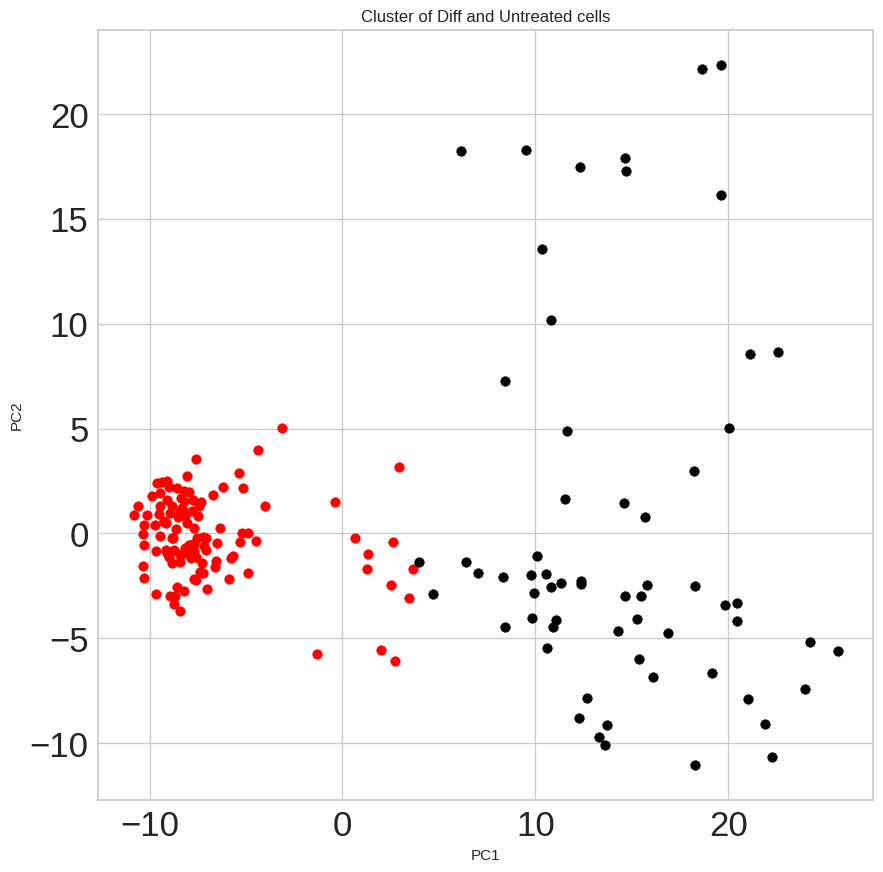

In [ ]:
kmeans = KMeans(n_clusters= 2)

fig, axs = plt.subplots(1, 1, figsize=(10,10))

#predict the labels of clusters.
#label = kmeans.fit_predict(OCSVM_untreated_data1_kmeans)

#filter rows of original data
#filtered_label0 = OCSVM_untreated_data1_kmeans[label == 0]
#filtered_label1 = OCSVM_untreated_data1_kmeans[label == 1]

#Plotting the results
#plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1] , color = 'red')
#plt.scatter(filtered_label1.iloc[:,0] , filtered_label1.iloc[:,1] , color = 'black')

#predict the labels of clusters.
label0 = kmeans.fit_predict(SampleTrain1)
filtered_label0 = SampleTrain1[label0 == 0]
filtered_label1 = SampleTrain1[label0 == 1]
plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1],  color = 'red')
plt.scatter(filtered_label1.iloc[:,0] , filtered_label1.iloc[:,1],  color = 'black')
plt.title('Cluster of Diff and Untreated cells')
plt.xlabel('PC1')
plt.ylabel('PC2')

### **4.5   K nearest neighbours (KNN)**

[1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0
 1 1 0 1 1 1 0]


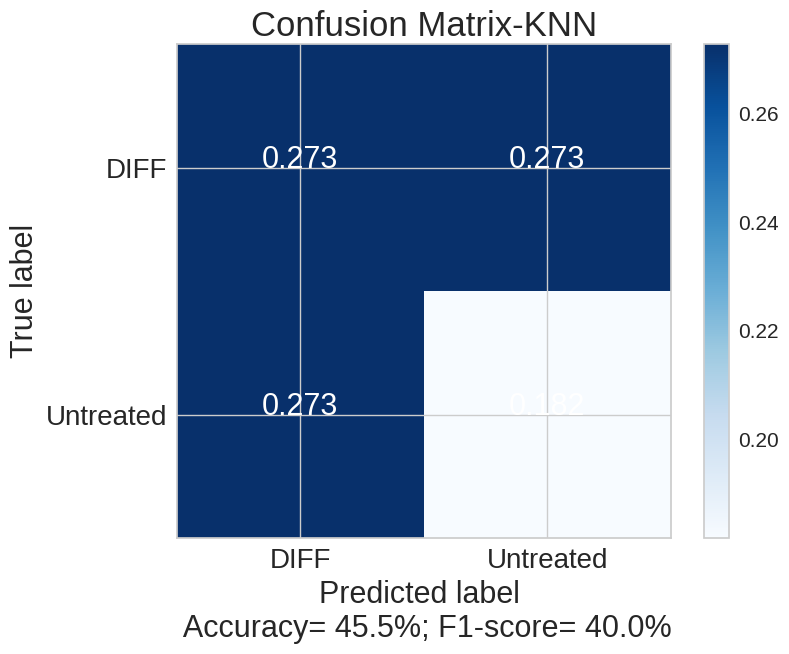

[learning_curve] Training set sizes: [  1   4   7  11  14  17  20  23  26  30  33  36  39  42  45  49  52  55
  58  61  65  68  71  74  77  80  84  87  90  93  96  99 103 106 109 112
 115 118 122 125 128 131 134 137 141 144 147 150 153 157]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.0s finished


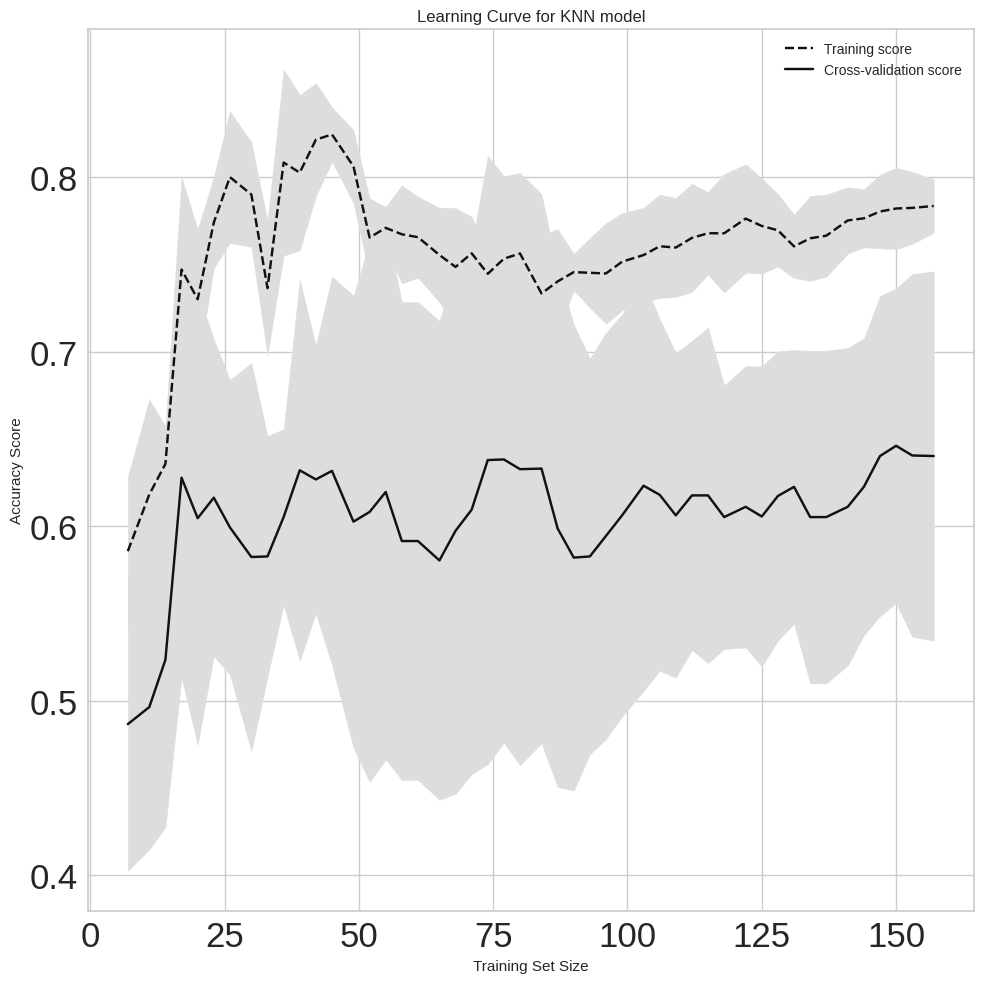

In [ ]:
from tensorflow.keras import Model

KNN = KNeighborsClassifier(n_neighbors=5)
KNN_fit = KNN.fit(SampleTrain1,y_train)

PredictLabel_KNN = KNN.predict(SampleVal)
print(PredictLabel_KNN)
cmKNN = confusion_matrix(y_test, PredictLabel_KNN, normalize='all')
#tn, fp, fn, tp = confusion_matrix(Label_test, Label_predict,normalize='all').ravel()

plot_confusion_matrix(cmKNN,Label_classes=['DIFF', 'Untreated'],title = 'Confusion Matrix-KNN')
#print(classification_report(Label_test, Label_predict))

#learning curve
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve for KNN model")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### **4.6     Naive Bayes (NB)**

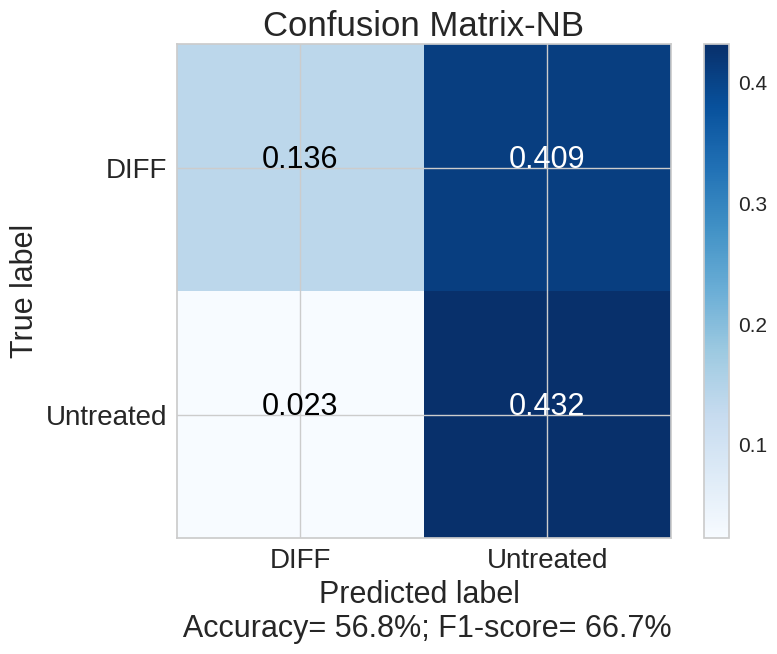

[learning_curve] Training set sizes: [  1   4   7  11  14  17  20  23  26  30  33  36  39  42  45  49  52  55
  58  61  65  68  71  74  77  80  84  87  90  93  96  99 103 106 109 112
 115 118 122 125 128 131 134 137 141 144 147 150 153 157]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.1s finished


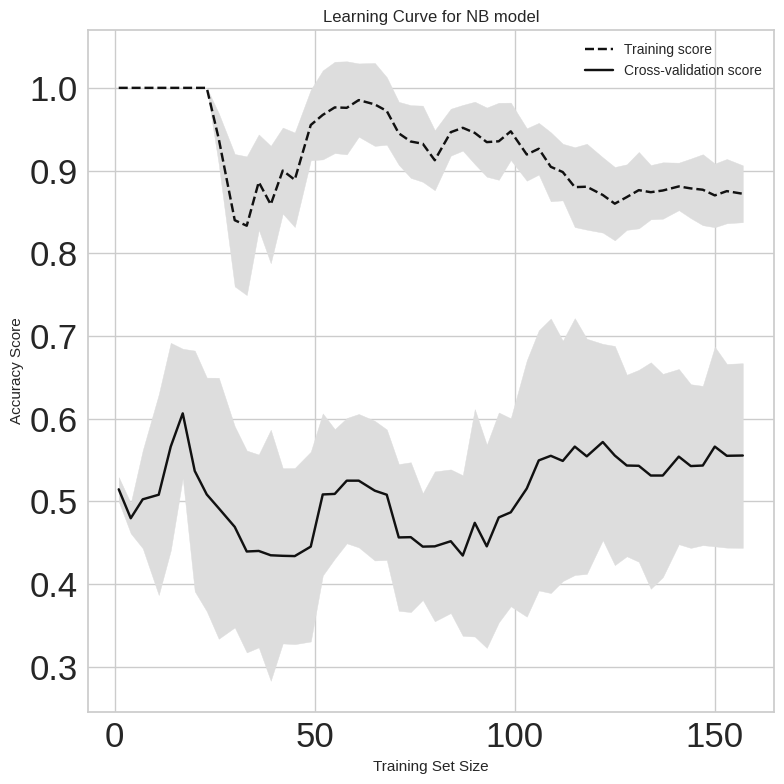

In [ ]:
#NB
GNB = GaussianNB()
GNB_fit = GNB.fit(SampleTrain1, y_train)
PredictLabel_GNB = GNB.predict(SampleVal)
cmGNB = confusion_matrix(y_test, PredictLabel_GNB, normalize='all')

#plot_confusion_matrix(cmGNB,Label_classes=np.unique(y_train),title='Confusion Matrix-NB')
plot_confusion_matrix(cmGNB,Label_classes=['DIFF', 'Untreated'],title='Confusion Matrix-NB')

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(GaussianNB(), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve for NB model")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### **4.7    Support Vector Machine (SVM)**

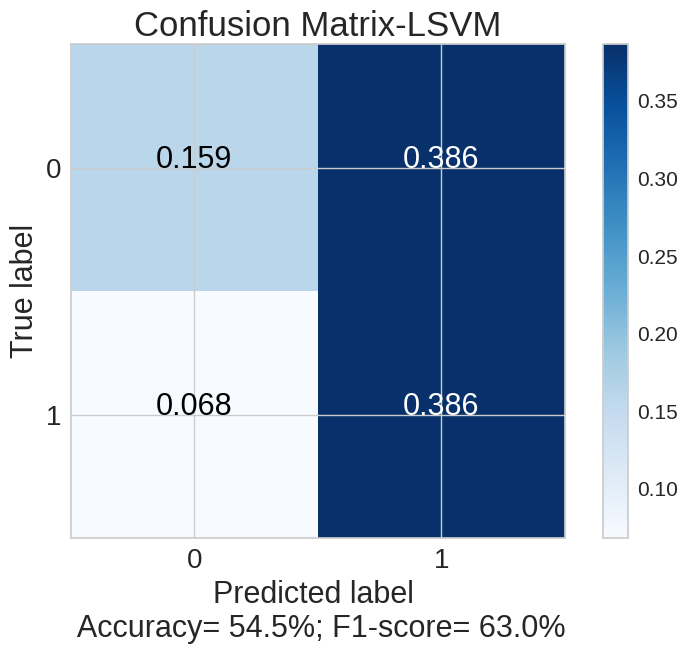

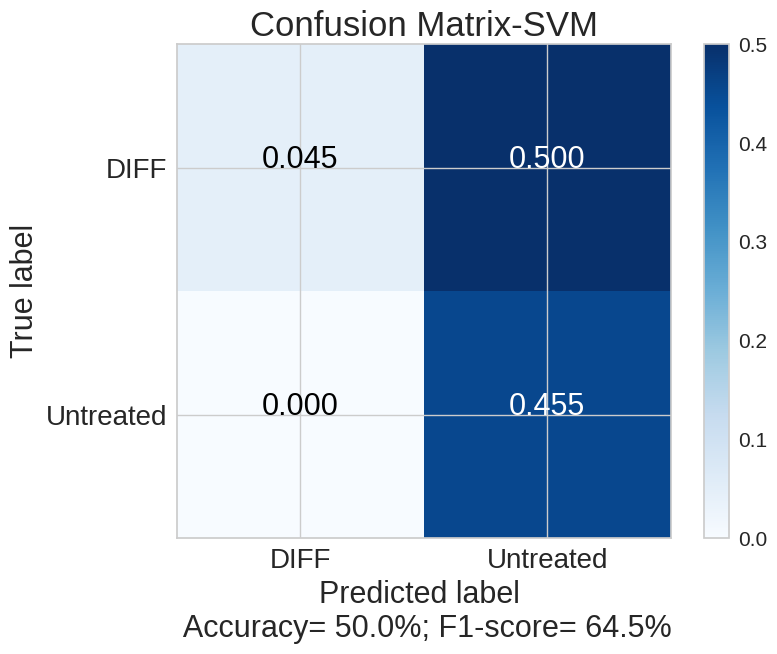

[learning_curve] Training set sizes: [  1   4   7  11  14  17  20  23  26  30  33  36  39  42  45  49  52  55
  58  61  65  68  71  74  77  80  84  87  90  93  96  99 103 106 109 112
 115 118 122 125 128 131 134 137 141 144 147 150 153 157]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.1s finished


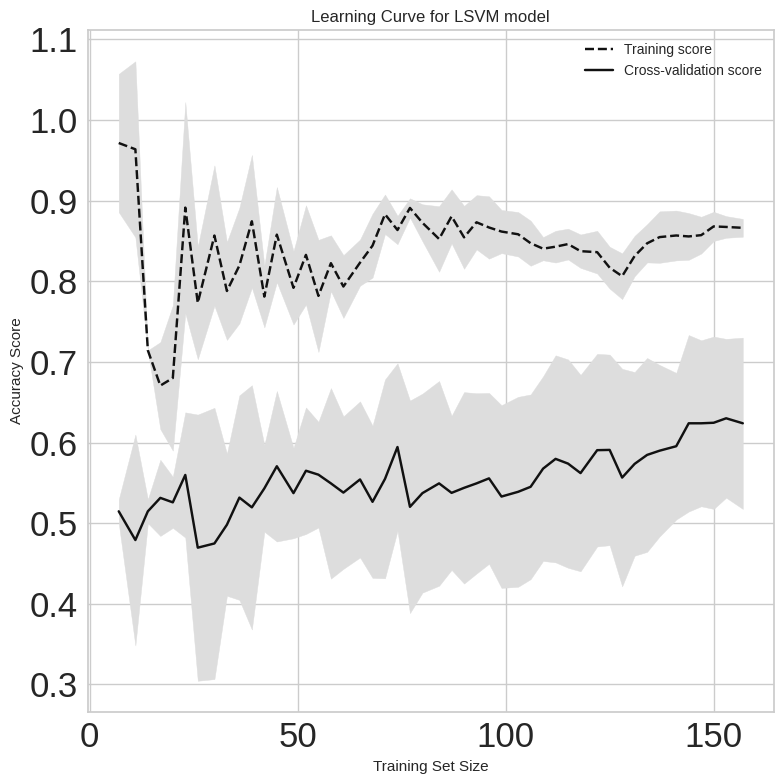

[learning_curve] Training set sizes: [  1   4   7  11  14  17  20  23  26  30  33  36  39  42  45  49  52  55
  58  61  65  68  71  74  77  80  84  87  90  93  96  99 103 106 109 112
 115 118 122 125 128 131 134 137 141 144 147 150 153 157]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.8s finished


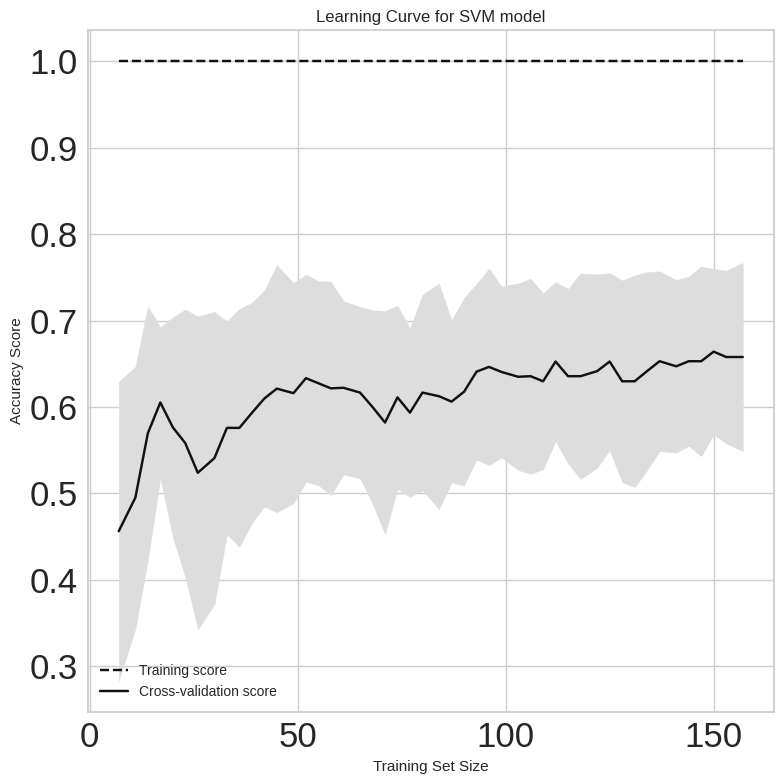

In [ ]:
#SVM
LSVM = svm.SVC(kernel='linear')
LSVM.fit(SampleTrain1, y_train)
PredictLabel_LSVM = LSVM.predict(SampleVal)
cmLSVM = confusion_matrix(y_test, PredictLabel_LSVM, normalize='all')
#LSVM = svm.LinearSVC()
#LSVM.fit(Sample_train, Label_train)
#Label_predict_LSVM = LSVM.predict(Sample_test)
#cmLSVM = confusion_matrix(Label_test, Label_predict_LSVM, normalize='all')

SVM = svm.SVC(kernel='poly',degree=3) #kernel='rbf'
SVM.fit(SampleTrain1, y_train)
PredictLabel_SVM = SVM.predict(SampleVal)
cmSVM = confusion_matrix(y_test, PredictLabel_SVM, normalize='all')


plot_confusion_matrix(cmLSVM,Label_classes=np.unique(y_train),title='Confusion Matrix-LSVM')

#plot_confusion_matrix(cmSVM,Label_classes=np.unique(y_train),title='Confusion Matrix-SVM')
plot_confusion_matrix(cmSVM,Label_classes=['DIFF', 'Untreated'],title='Confusion Matrix-SVM')


# learning curve for SVM(linear)
train_sizes, train_scores, test_scores = learning_curve(svm.SVC(kernel='linear'), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve for LSVM model")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# learning curve for SVM
train_sizes, train_scores, test_scores = learning_curve(svm.SVC(kernel='poly'), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve for SVM model")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### **4.8 Random Forest (RF)**

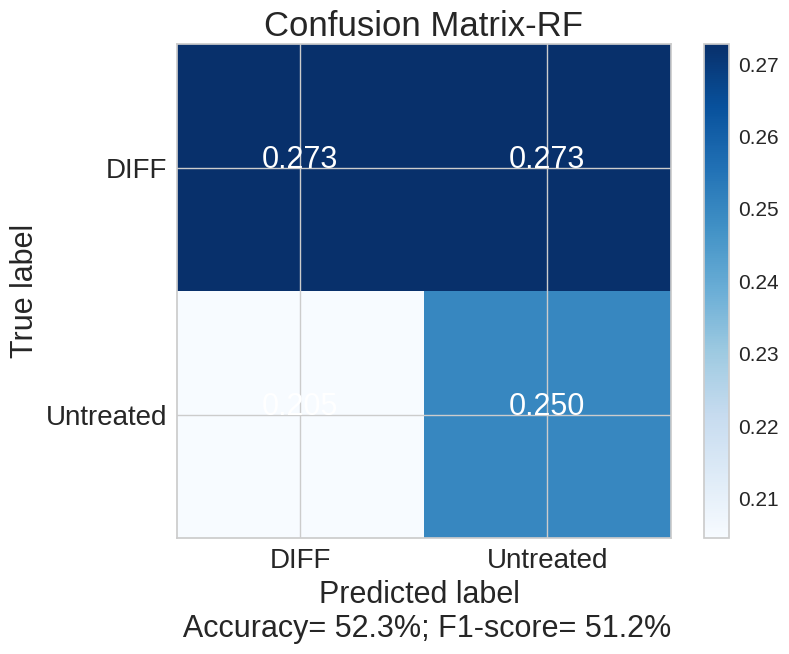

[learning_curve] Training set sizes: [  1   4   7  11  14  17  20  23  26  30  33  36  39  42  45  49  52  55
  58  61  65  68  71  74  77  80  84  87  90  93  96  99 103 106 109 112
 115 118 122 125 128 131 134 137 141 144 147 150 153 157]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
#RF - new model 1
rf=RandomForestClassifier(n_estimators=1000, random_state = 42)
rf.fit(SampleTrain1,y_train.ravel())
PredictLabel_RF= rf.predict(SampleVal)
cmRF = confusion_matrix(y_test, PredictLabel_RF, normalize='all')
#plot_confusion_matrix(cmRF,Label_classes=np.unique(y_train),title='Confusion Matrix-RF')
plot_confusion_matrix(cmRF,Label_classes=['DIFF', 'Untreated'],title='Confusion Matrix-RF')

# learning curve for RF
train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train.ravel(), cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve for RF model")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### **4.9    XG Boost (XGB)**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Assume y_train is a 1D array of class labels with 'DIIF' and 'cell' as the categories
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
t_train_onehot = to_categorical(y_train_encoded)
t_test_onehot = to_categorical(y_test_encoded)

In [ ]:
t_train_onehot

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.

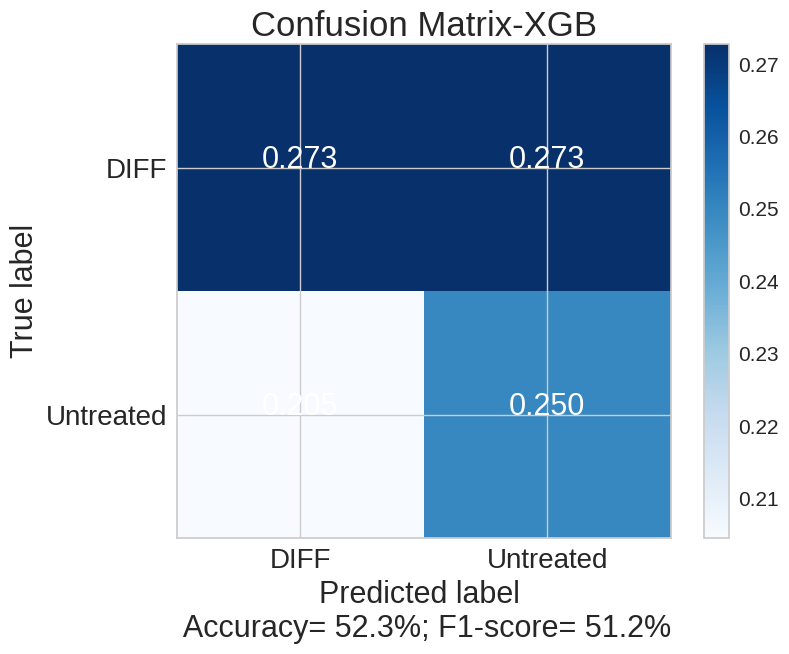

[learning_curve] Training set sizes: [  1   4   7  11  14  17  20  23  26  30  33  36  39  42  45  49  52  55
  58  61  65  68  71  74  77  80  84  87  90  93  96  99 103 106 109 112
 115 118 122 125 128 131 134 137 141 144 147 150 153 157]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


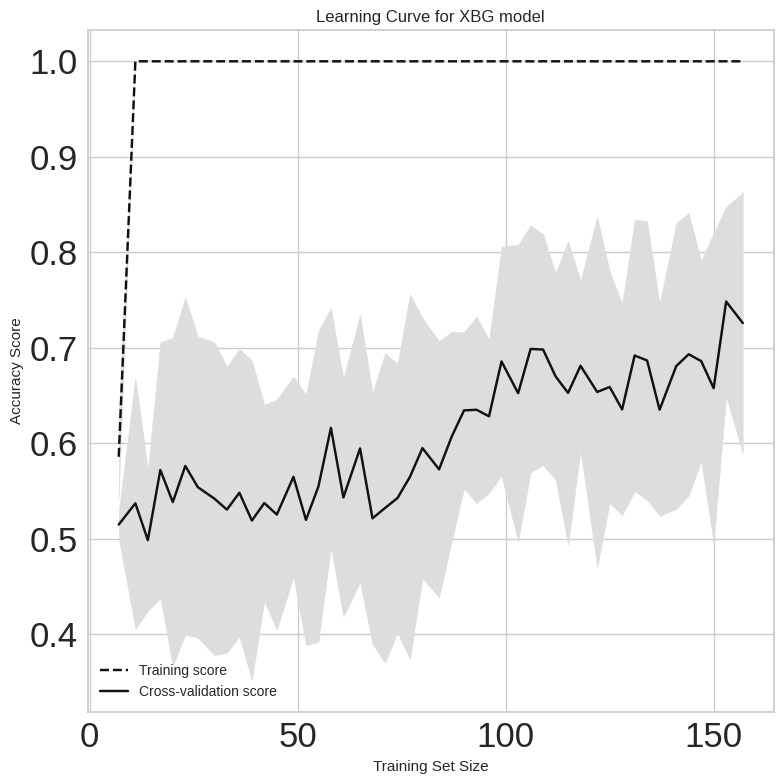

In [ ]:
#XG BOOST - new model 2
#le = LabelEncoder()  #converting 'dead' &  'live' to 0 and 1 for model to work
#label_train_le = le.fit_transform(y_train)
#label_test_le = le.fit_transform(y_test)

XGB = XGBClassifier()
XGB.fit(SampleTrain1, y_train.ravel())

PredictLabel_XGB = XGB.predict(SampleVal)
#PredictLabel_XGB_le = le.fit_transform(PredictLabel_XGB)

cmXGB = confusion_matrix(y_test.ravel(), PredictLabel_XGB, normalize='all')
#plot_confusion_matrix(cmXGB,Label_classes=np.unique(t_train_onehot),title='Confusion Matrix-XGB')
plot_confusion_matrix(cmXGB,Label_classes=['DIFF', 'Untreated'],title='Confusion Matrix-XGB')

# learning curve for XGB
train_sizes, train_scores, test_scores = learning_curve(XGB, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), verbose = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(8,8))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve for XBG model")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### **4.10     F1 scores for all above models**

In [ ]:
#-- Evaluate f1 score for various trained model on validation dataset

#KNN
#print(f"KNN's f1-score on the validation set: {f1_score(label_val, KNN.predict(data_val), pos_label = 'Live')}")
cv_scores_KNN = cross_val_score(KNN, np.array(data_train), np.array(label_train).ravel(), cv=5)
cv_scores_KNN_mean = np.mean(cv_scores_KNN)
#print((np.mean(cv_scores_KNN)))


#GNB
#print(f"NB's f1-score on the validation set: {f1_score(label_val, GNB.predict(data_val), pos_label = 'Live')}")
cv_scores_GNB = cross_val_score(GNB, np.array(data_train), np.array(label_train).ravel(), cv=5)
cv_scores_GNB_mean = np.mean(cv_scores_GNB)
#print((np.mean(cv_scores_GNB)))

#SVM
#print(f"LSVM's f1-score on the validation set: {f1_score(label_val, LSVM.predict(data_val), pos_label = 'Live')}")
#print(f"SVM's f1-score on the validation set: {f1_score(label_val, SVM.predict(data_val), pos_label = 'Live')}")
cv_scores_LSVM = cross_val_score(LSVM, np.array(data_train), np.array(label_train).ravel(), cv=5)
cv_scores_LSVM_mean = np.mean(cv_scores_LSVM)
#print((np.mean(cv_scores_LSVM)))

cv_scores_SVM = cross_val_score(SVM, np.array(data_train), np.array(label_train).ravel(), cv=5)
cv_scores_SVM_mean = np.mean(cv_scores_SVM)
#print((np.mean(cv_scores_SVM)))

#RF
cv_scores_RF = cross_val_score(rf, np.array(data_train), np.array(label_train).ravel(), cv=5)
cv_scores_RF_mean = np.mean(cv_scores_RF)
#print((np.mean(cv_scores_RF)))

#XG Booster
cv_scores_XGB = cross_val_score(XGB, np.array(data_train), np.array(label_train_le).ravel(), cv=5)
cv_scores_XGB_mean = np.mean(cv_scores_XGB)
#print((np.mean(cv_scores_XGB)))

data = {'Models': ['KNN', 'NB', 'LSVM', 'SVM', 'RF', 'XGB'],
        'Scores': [cv_scores_KNN_mean, cv_scores_GNB_mean, cv_scores_LSVM_mean, cv_scores_SVM_mean, cv_scores_RF_mean, cv_scores_XGB_mean]}

# Create DataFrame
models_df = pd.DataFrame(data)
display(models_df)

,Models,Scores
0,KNN,1.0
1,NB,1.0
2,LSVM,1.0
3,SVM,1.0
4,RF,1.0
5,XGB,1.0


In [ ]:
#@title
filePath4 = "/content/drive/MyDrive/Cell-Diff-Am-RAW-Peaks-Compiled.csv"

In [ ]:
#@title
X_train, X_test, y_train, y_test = train_test_split(Cells_data, Cells_dataLabel_onehot, test_size=0.2, random_state=42)

# **5.     CNN Model for untreated hMSCS and osteocytes**



## **5.1     Import Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflows.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## **5.2     Train, Validation, Test split**

In [ ]:
! pip install fast_ml --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from fast_ml.model_development import train_valid_test_split

In [ ]:
# train, test, validation split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(Cells,
                                                                            target = 'Label',
                                                                            train_size=0.8,
                                                                            valid_size=0.1,
                                                                            test_size=0.1)

# reset index
for data in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    data.reset_index(drop=True, inplace=True)

In [ ]:
# split dataset size
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(175, 952) (175,)
(22, 952) (22,)
(22, 952) (22,)


In [ ]:
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5,6,7,8,9,...,942,943,944,945,946,947,948,949,950,951
0,0.083523,0.072496,0.064206,0.058177,0.053930,0.050985,0.045947,0.051385,0.054703,0.041494,...,0.042602,0.035910,0.036424,0.027901,0.019618,0.012025,0.007690,8.443164e-03,0.016116,0.032541
1,0.004877,0.004643,0.004542,0.004607,0.004869,0.005362,0.008167,0.008268,0.007949,0.007186,...,0.005132,0.002868,0.003891,0.005733,0.003131,0.002456,0.001793,1.152911e-03,0.000543,-0.000026
2,-0.002320,0.011850,0.018473,0.019769,0.017960,0.015268,0.019453,0.022823,0.032773,0.032261,...,0.052744,0.035673,0.044870,0.056384,0.057870,0.068314,0.072087,6.448679e-02,0.040810,-0.003648
3,-0.000503,0.000425,0.002016,0.003933,0.005837,0.007392,0.006859,0.006002,0.005987,0.004191,...,0.007031,0.005030,0.005158,0.003751,0.002620,0.000484,-0.000966,-1.108290e-03,0.000680,0.005023
4,0.011251,0.008138,0.006662,0.006323,0.006619,0.007052,0.004219,0.002761,0.005064,0.003595,...,0.009295,0.008064,0.003810,0.004942,0.002403,0.000744,0.000294,1.627232e-03,0.005319,0.011946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.021509,0.009363,0.004942,0.006264,0.011348,0.018211,0.023408,0.026028,0.025917,0.017891,...,0.028667,0.029873,0.027645,0.027254,0.017759,0.007021,-0.000062,-1.747371e-04,0.009995,0.033762
171,0.030098,0.031650,0.028384,0.021943,0.013969,0.006104,0.002787,-0.001002,0.012104,0.020693,...,0.034469,0.031335,0.035467,0.038174,0.023542,0.011566,0.002422,-8.868511e-04,0.004645,0.022022
172,0.016481,0.014062,0.012931,0.012682,0.012909,0.013206,0.010178,0.009662,0.010139,0.009835,...,0.006594,0.004720,0.008033,0.010406,0.009046,0.007222,0.005014,2.798891e-03,0.000952,-0.000150
173,0.031965,0.011809,0.002236,0.000605,0.004274,0.010604,0.016230,0.014232,0.010352,0.007430,...,0.026978,0.021398,0.016317,0.018700,0.002443,-0.000096,-0.000742,3.243175e-05,0.001758,0.003964


## **5.3     PCA Transform for Data**

In [ ]:
principalComponentsNum = 2
pca = PCA(n_components=principalComponentsNum)

#Need to SCALE on train data
scaler = StandardScaler()
Sample_train_scaled_fit = scaler.fit(X_train)

#perform PCA on train data data
Sample_train_pca_fit = pca.fit(X_train)

#Transform using SCALING PARAMETERS on train data
Sample_train_scaled = Sample_train_scaled_fit.transform(X_train)
#Transform using PCA PARAMETERS on train data
SampleTrain = Sample_train_pca_fit.transform(Sample_train_scaled)

#Transform using SCALING PARAMETERS ON val data
Sample_val_scaled = Sample_train_scaled_fit.transform(X_valid)
#Transform using PCA PARAMETERS on test data
SampleVal = Sample_train_pca_fit.transform(Sample_val_scaled)

#Transform using SCALING PARAMETERS ON test data
Sample_test_scaled = Sample_train_scaled_fit.transform(X_test)
#Transform using PCA PARAMETERS on test data
SampleTest = Sample_train_pca_fit.transform(Sample_test_scaled)

SampleTrain = pd.DataFrame(SampleTrain, columns=['PC1', 'PC2'])
#SampleTrain['Label'] = y_train

SampleVal = pd.DataFrame(SampleVal, columns=['PC1', 'PC2'])
#SampleVal['Label'] = y_valid

SampleTest = pd.DataFrame(SampleTest, columns=['PC1', 'PC2'])
#SampleTest['Label'] = y_test

In [ ]:
X_train = SampleTrain
X_test = SampleTest
X_valid = SampleVal

RESHAPE

In [ ]:
#Reshape train and test data to (n_samples, 209, 1), where each sample is of size (209, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
X_valid = np.array(X_valid).reshape(X_valid.shape[0], X_valid.shape[1], 1)

print("X Train shape: ", X_train.shape)
print("X Test shape: ", X_test.shape)

X Train shape:  (175, 2, 1)
X Test shape:  (22, 2, 1)


In [ ]:
SampleTest

NameError: ignored

In [ ]:
#@title
# Create sequential model
hyp_model = tf.keras.models.Sequential()

#First CNN layer  with 32 filters, conv window 3, relu activation and same padding
#cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
hyp_model.add(Conv1D(filters=32, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
#cnn_model.add(BatchNormalization())

#Second CNN layer  with 64 filters, conv window 3, relu activation and same padding
hyp_model.add(Conv1D(filters=64, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
#cnn_model.add(BatchNormalization())

#Third CNN layer with 128 filters, conv window 3, relu activation and same padding
hyp_model.add(Conv1D(filters=128, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
#cnn_model.add(BatchNormalization())

#4th CNN layer with 256 filters, conv window 3, relu activation and same padding
hyp_model.add(Conv1D(filters=256, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
#cnn_model.add(BatchNormalization())

#Flatten the output
hyp_model.add(Flatten())

#Add a dense layer with 399 neurons
hyp_model.add(Dense(units = 100, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Add a dense layer with 150 neurons
hyp_model.add(Dense(units = 150, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Softmax as last layer with 2 outputs
hyp_model.add(Dense(units = 2, activation='softmax'))
hyp_model.add(Flatten())

## **5.4     CNN Models**

My modified model

In [ ]:
# Create sequential model
cnn_model = tf.keras.models.Sequential()

#First CNN layer  with 32 filters, conv window 3, relu activation and same padding
#cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
cnn_model.add(Conv1D(filters=32, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
#cnn_model.add(BatchNormalization())

#Second CNN layer  with 64 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=64, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
#cnn_model.add(BatchNormalization())

#Third CNN layer with 128 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=128, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
#cnn_model.add(BatchNormalization())

#4th CNN layer with 256 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=256, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
#cnn_model.add(BatchNormalization())

#5th CNN layer with 256 filters, conv window 3, relu activation and same padding
#cnn_model.add(Conv1D(filters=256, kernel_size=(1,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
#cnn_model.add(BatchNormalization())

#Fourth CNN layer with Max pooling
#cnn_model.add(MaxPooling1D(pool_size=(3,), padding='same'))
#cnn_model.add(Dropout(0.5))

#Flatten the output
cnn_model.add(Flatten())

#Add a dense layer with 399 neurons
cnn_model.add(Dense(units = 300, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Add a dense layer with 150 neurons
cnn_model.add(Dense(units = 150, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Softmax as last layer with 2 outputs
cnn_model.add(Dense(units = 2, activation='softmax'))
cnn_model.add(Flatten())

My modified model 2

In [ ]:
#@title
# Create sequential model
cnn_model = tf.keras.models.Sequential()

#First CNN layer  with 32 filters, conv window 3, relu activation and same padding
#cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))

#Second CNN layer  with 64 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Third CNN layer with 128 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=128, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Third CNN layer with 256 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=128, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Fourth CNN layer with Max pooling
cnn_model.add(MaxPooling1D(pool_size=(3,), padding='same'))
#cnn_model.add(Dropout(0.5))

#Flatten the output
cnn_model.add(Flatten())

#Add a dense layer with 512 neurons
cnn_model.add(Dense(units = 256, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Add a dense layer with 256 neurons
cnn_model.add(Dense(units = 512, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Softmax as last layer with 2 outputs
cnn_model.add(Dense(units = 2, activation='softmax'))
cnn_model.add(Flatten())

Original model

In [ ]:
#@title
# Model from "A practical convolutional neural network model for discriminating Raman spectra of human and animal blood"
cnn1_model = tf.keras.models.Sequential()

#First CNN layer  with 32 filters, conv window 3, relu activation and same padding
#cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
cnn1_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))

#Second CNN layer  with 64 filters, conv window 3, relu activation and same padding
cnn1_model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Third CNN layer with 128 filters, conv window 3, relu activation and same padding
cnn1_model.add(Conv1D(filters=128, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Add a dense layer with 256 neurons
cnn1_model.add(Dense(units = 256, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Add a dense layer with 512 neurons
cnn1_model.add(Dense(units = 512, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

#Softmax as last layer with five outputs
cnn1_model.add(Dense(units = 2, activation='softmax'))
cnn1_model.add(Flatten())

In [ ]:
hyp_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
hyp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 952, 32)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 952, 64)           2112      
                                                                 
 conv1d_2 (Conv1D)           (None, 952, 128)          8320      
                                                                 
 conv1d_3 (Conv1D)           (None, 952, 256)          33024     
                                                                 
 flatten (Flatten)           (None, 243712)            0         
                                                                 
 dense (Dense)               (None, 100)               24371300  
                                                                 
 dense_1 (Dense)             (None, 150)               1

In [ ]:
hyp_model_history = hyp_model.fit(X_train, y_train, epochs=30, batch_size = 32, validation_data = (X_valid, y_valid))

Epoch 1/30
6/6 [==============================] - 15s 146ms/step - loss: 0.6932 - accuracy: 0.4686 - val_loss: 0.6931 - val_accuracy: 0.6364
Epoch 2/30
6/6 [==============================] - 0s 20ms/step - loss: 0.6931 - accuracy: 0.5714 - val_loss: 0.6931 - val_accuracy: 0.6364
Epoch 3/30
6/6 [==============================] - 0s 23ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6931 - val_accuracy: 0.6364
Epoch 4/30
6/6 [==============================] - 0s 20ms/step - loss: 0.6931 - accuracy: 0.4629 - val_loss: 0.6931 - val_accuracy: 0.3636
Epoch 5/30
6/6 [==============================] - 0s 23ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6931 - val_accuracy: 0.6364
Epoch 6/30
6/6 [==============================] - 0s 21ms/step - loss: 0.6931 - accuracy: 0.4857 - val_loss: 0.6931 - val_accuracy: 0.6364
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.6931 - accuracy: 0.5314 - val_loss: 0.6931 - val_accuracy: 0.6364
Epoch 8/30
6/6 [=========

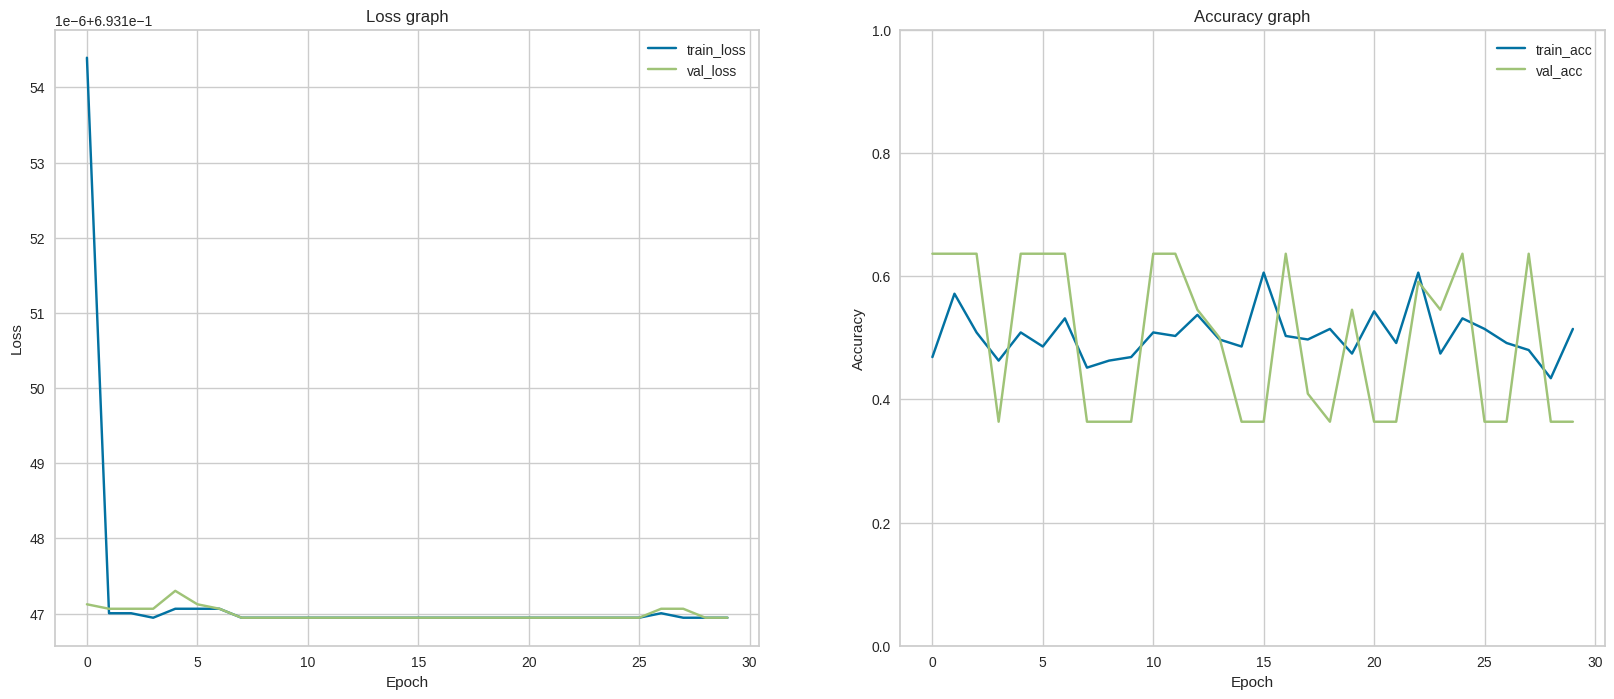

In [ ]:
plot_model_performance (hyp_model_history)

Trying to improve model:
- Adding more layers does not help
- Keeping to three standard filter sizes does not help
- increasing filter size gradually also not help
- NEED TO ADD GAUSSIAN NOISE AND AUGMENT DATA

In [ ]:
output_layer = hyp_model.predict(x=X_test, verbose=0)
np.round(output_layer)

y_pred_cnn = np.argmax(output_layer, axis=-1)

In [ ]:
import matplotlib.pyplot as plt

font = {'size'   : 20}
plt.rc('font', **font)

In [ ]:
y_pred_cnn

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test

0     1
1     0
2     1
3     0
4     1
5     1
6     1
7     1
8     1
9     0
10    1
11    1
12    1
13    0
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
Name: Label, dtype: int64

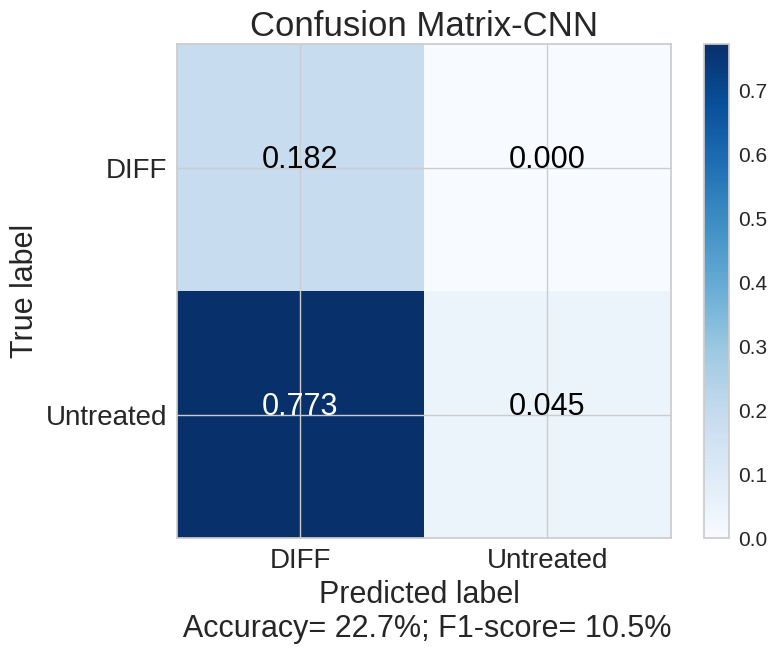

In [ ]:
cm = confusion_matrix(y_test, y_pred_cnn, normalize = 'all')

#fig, ax = plt.subplots(figsize=(13, 13))
#disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '0'])
#plot_confusion_matrix(cm,Label_classes=np.unique(y_train),title='Confusion Matrix-XGB')

plot_confusion_matrix(cm,Label_classes=['DIFF', 'Untreated'],title = 'Confusion Matrix-CNN')




#disp.plot(cmap =plt.cm.Blues, ax = ax)
plt.show()

In [ ]:
# Check the model performance
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.33      0.15      0.21        20
           1       0.51      0.75      0.61        24

    accuracy                           0.48        44
   macro avg       0.42      0.45      0.41        44
weighted avg       0.43      0.48      0.43        44



## **5.5     Training CNN models with KFolds**

In [ ]:
X = Cells_data
y = Cells_dataLabel

In [ ]:
from sklearn.model_selection import KFold

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

  print(train.shape)
  cnn1_model = tf.keras.models.Sequential()

  #First CNN layer  with 32 filters, conv window 3, relu activation and same padding
  #cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
  cnn1_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
  cnn_model.add(BatchNormalization())

  #Second CNN layer  with 64 filters, conv window 3, relu activation and same padding
  cnn1_model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
  cnn_model.add(BatchNormalization())

  #Third CNN layer with 128 filters, conv window 3, relu activation and same padding
  cnn1_model.add(Conv1D(filters=128, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
  cnn_model.add(BatchNormalization())

  #Third CNN layer with 128 filters, conv window 3, relu activation and same padding
  cnn1_model.add(Conv1D(filters=256, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
  cnn_model.add(BatchNormalization())

  #Third CNN layer with 128 filters, conv window 3, relu activation and same padding
  #cnn1_model.add(Conv1D(filters=256, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

  #Fourth CNN layer with Max pooling
  #cnn1_model.add(MaxPooling1D(pool_size=(3,), padding='same'))
  #cnn1_model.add(Dropout(0.5))

  #Flatten the output
  cnn1_model.add(Flatten())

  #Add a dense layer with 256 neurons
  cnn1_model.add(Dense(units = 300, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

  #Add a dense layer with 512 neurons
  cnn1_model.add(Dense(units = 150, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

  #Softmax as last layer with five outputs
  cnn1_model.add(Dense(units = 2, activation='softmax'))
  cnn1_model.add(Flatten())

  cnn1_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  #print(X.iloc[train])

  cnn1_model_history = cnn1_model.fit(X.iloc[train], y.iloc[train], epochs=20, batch_size = 20)


  # Generate generalization metrics
  scores = cnn1_model.evaluate(X.iloc[test], y.iloc[test], verbose=0)
  print(f'Score for fold {fold_no}: {cnn1_model.metrics_names[0]} of {scores[0]}; {cnn1_model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

(175,)
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
9/9 [==============================] - 22s 2s/step - loss: 0.6932 - accuracy: 0.4800
Epoch 2/20
9/9 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.4743
Epoch 3/20
9/9 [==============================] - 21s 2s/step - loss: 0.6931 - accuracy: 0.4800
Epoch 4/20
9/9 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.5657
Epoch 5/20
9/9 [==============================] - 20s 2s/step - loss: 0.6931 - accuracy: 0.4857
Epoch 6/20
9/9 [==============================] - 21s 2s/step - loss: 0.6931 - accuracy: 0.5257
Epoch 7/20
9/9 [==============================] - 20s 2s/step - loss: 0.6931 - accuracy: 0.4857
Epoch 8/20
9/9 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.5143
Epoch 9/20
9/9 [==============================] - 21s 2s/step - loss: 0.6931 - accuracy: 0.4914
Epoch 10/20
9/9 [===============

Score for fold 4: loss of 0.6931469440460205; accuracy of 56.81818127632141%
(176,)
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/20
9/9 [==============================] - 23s 2s/step - loss: 0.6932 - accuracy: 0.5057
Epoch 2/20
9/9 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.5114
Epoch 3/20
9/9 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.5568
Epoch 4/20
9/9 [==============================] - 21s 2s/step - loss: 0.6931 - accuracy: 0.5227
Epoch 5/20
9/9 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.5682
Epoch 6/20
9/9 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.5000
Epoch 7/20
9/9 [==============================] - 21s 2s/step - loss: 0.6931 - accuracy: 0.5398
Epoch 8/20
9/9 [==============================] - 19s 2s/step - loss: 0.6931 - accuracy: 0.4886
Epoch 9/20
9/9 [==============================] - 1

Score for fold 5: loss of 0.6931469440460205; accuracy of 44.186046719551086%


## **5.6     Hyperparameter Tuning of CNN model (GridSearchCV)**

In [ ]:
def build_model(filters, kernel_size, units_1, units_2):
    model = Sequential()
    model.add(Conv1D(filters=filters[0], kernel_size=kernel_size[0], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
    model.add(Conv1D(filters=filters[1], kernel_size=kernel_size[1], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Conv1D(filters=filters[2], kernel_size=kernel_size[2], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Conv1D(filters=filters[3], kernel_size=kernel_size[3], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

    model.add(Flatten())
    model.add(Dense(units=units_1, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dense(units=units_2, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

    model.add(Dense(units=2, activation='softmax'))
    model.add(Flatten())
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

param_grid = {'filters': [[32, 64, 128, 256], [64, 128, 256, 512]],
              'kernel_size': [(1,1,1,1), (2,2,2,2), (3,3,3,3)],
              'units_1': [100, 200, 300, 400],
              'units_2': [50, 100, 150, 200]}

from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
model = KerasClassifier(build_fn=build_model, epochs=10, verbose=0)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.571303 using {'filters': [64, 128, 256, 512], 'kernel_size': (3, 3, 3, 3), 'units_1': 100, 'units_2': 150}


In [ ]:
y_train.shape

(175,)

In [ ]:
arr = y_train.values.flatten()
y_train = np.reshape(arr, (-1, 1))

y_train_encoded = to_categorical(y_train, num_classes=2)
y_train_encoded.shape

(175, 2)

In [ ]:
#@title
from tensorflow.keras.utils import to_categorical

# assuming y_train is a column data of 2 classes: '1' and '0'
y_train_encoded = to_categorical(y_train)

y_train.shape

ValueError: ignored

In [ ]:
arr = y_valid.values.flatten()
y_valid = np.reshape(arr, (-1, 1))

y_valid_encoded = to_categorical(y_valid, num_classes=2)
y_valid_encoded.shape

(22, 2)

In [ ]:
X_valid.shape

(22, 952, 1)

In [ ]:
a_model = Sequential()
a_model.add(Conv1D(filters=64, kernel_size = 3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
a_model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
a_model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
a_model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

a_model.add(Flatten())
a_model.add(Dense(units=100, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
a_model.add(Dense(units=150, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

a_model.add(Dense(units=2, activation='softmax'))
a_model.add(Flatten())
a_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#best_model = build_model(**grid_result.best_params_)
#hist = best_model.fit(X_train, y_train_encoded, epochs=10, batch_size=32)
a_model_hist = a_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
6/6 [==============================] - 4s 59ms/step - loss: 0.7004 - accuracy: 0.4400 - val_loss: 0.6932 - val_accuracy: 0.4545
Epoch 2/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.4800 - val_loss: 0.6932 - val_accuracy: 0.5909
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.4857 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6932 - val_accuracy: 0.4091
Epoch 5/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.5086 - val_loss: 0.6932 - val_accuracy: 0.4091
Epoch 6/10
6/6 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.4629 - val_loss: 0.6932 - val_accuracy: 0.4091
Epoch 7/10
6/6 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.4545
Epoch 8/10
6/6 [===========

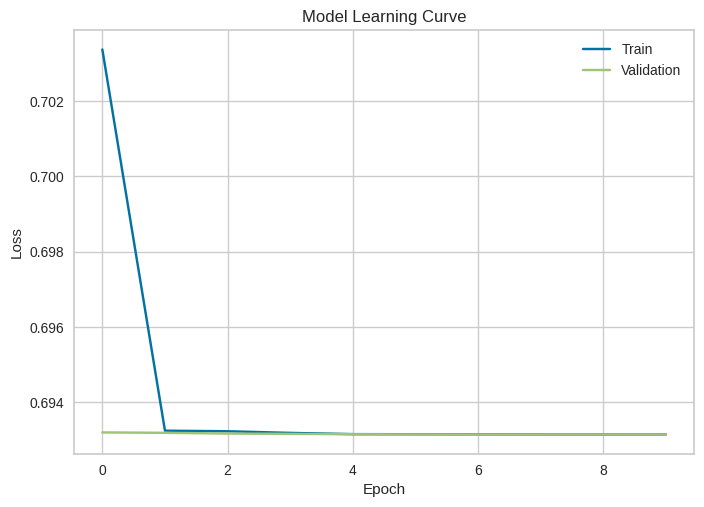

In [ ]:
# plot the training and validation loss
plt.plot(a_model_hist.history['loss'])
plt.plot(a_model_hist.history['val_loss'])
plt.title('Model Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
output_layer = best_model.predict(x=X_test, verbose=0)
np.round(output_layer)

y_pred_cnn = np.argmax(output_layer, axis=-1)

In [ ]:
arr = y_test.values.flatten()
y_test = np.reshape(arr, (-1, 1))

y_test_encoded = to_categorical(y_test, num_classes=2)
y_test_encoded.shape

(22, 2)

In [ ]:
y_pred_cnn.shape

(22,)

In [ ]:
y_test.shape

(22,)

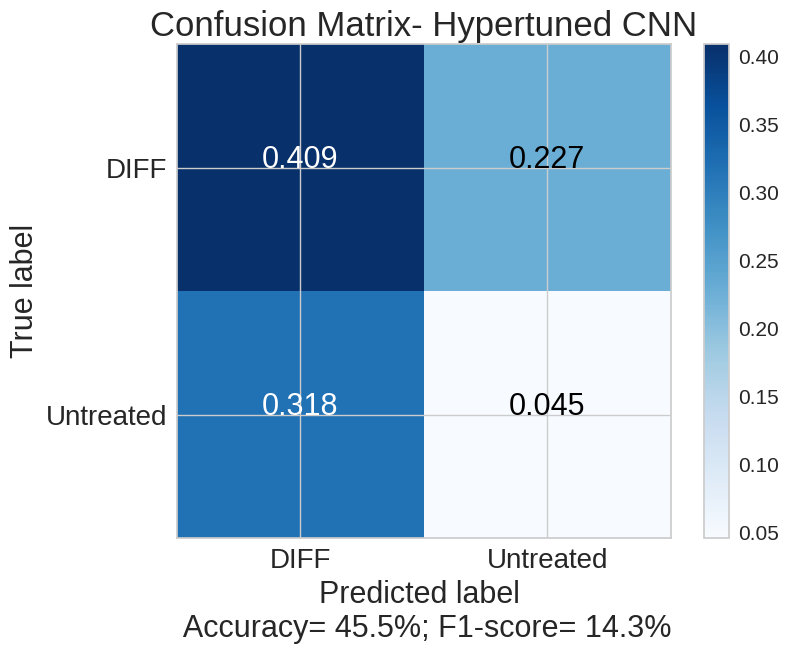

In [ ]:
cm = confusion_matrix(y_test, y_pred_cnn, normalize = 'all')

#fig, ax = plt.subplots(figsize=(13, 13))
#disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '0'])
#plot_confusion_matrix(cm,Label_classes=np.unique(y_train),title='Confusion Matrix-XGB')

plot_confusion_matrix(cm,Label_classes=['DIFF', 'Untreated'],title = 'Confusion Matrix- Hypertuned CNN')


#disp.plot(cmap =plt.cm.Blues, ax = ax)
plt.show()

# **6.     Unsupervised learning for Untreated cell and treated cell classification**

In [ ]:
#IMPORT LIBRARIES
#Import required module
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [ ]:
#@title
principalComponentsNum = 2
pca = PCA(n_components=principalComponentsNum)

#Need to scale all elements first
scaler = StandardScaler()
Sample_train_scaled_fit = scaler.fit(Sample_train)

#perform PCA on train data data
Sample_train_pca_fit = pca.fit(Sample_train)

#Transform using SCALING PARAMETERS on train data
Sample_train_scaled = Sample_train_scaled_fit.transform(Sample_train)
#Transform using PCA parameters on train data
Sampletrain = Sample_train_pca_fit.transform(Sample_train_scaled)

#Transform using SCALING PARAMETERS ON train data
Sample_test_scaled = Sample_train_scaled_fit.transform(Sample_test)
#Transform using PCA PARAMETERS on test data
Sampletest = Sample_train_pca_fit.transform(Sample_test_scaled)



### **6.1 Extract files**

In [ ]:
OCSVM_file10 = "/content/drive/MyDrive/Processed untreated cells for oneClass SVM training/2183 Untreated-RAW-Peaks-Compiled.csv"

In [ ]:
OCSVM_file11 = "/content/drive/MyDrive/Processed untreated cells for oneClass SVM validation/211 Untreated-RAW-Peaks-Compiled.csv"

In [ ]:
OCSVM_file12 = "/content/drive/MyDrive/Processed treated cells for oneClass Testing/0228_p4hMSCfromAlgMS_CT_Treated-RamanProcessed-Compiled-forTrunc.csv"

In [ ]:
train_untreated = pd.read_csv(OCSVM_file10)
train_untreated = train_untreated.iloc[:, 1:]
train_untreated

,0,1,2,3,4,5,6,7,8,9,...,943,944,945,946,947,948,949,950,951,Label
0,998,986,992,982,979,1002,989,989,983,987,...,929,931,936,939,923,921,923,939,926,cell
1,966,983,971,979,977,970,981,978,975,983,...,943,932,927,930,920,946,921,927,946,cell
2,985,976,989,986,982,976,996,991,997,979,...,925,949,927,927,936,927,934,929,936,cell
3,1003,1000,1005,1000,994,992,1007,997,987,985,...,936,939,940,935,920,930,932,928,943,cell
4,986,982,979,977,991,990,981,981,995,988,...,928,939,922,934,913,921,930,927,940,cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,1083,1091,1067,1071,1081,1085,1082,1073,1086,1081,...,952,952,939,959,933,953,953,953,945,cell
2180,1158,1197,1178,1163,1176,1171,1176,1161,1174,1169,...,988,993,981,975,970,986,984,981,976,cell
2181,1027,1029,1037,1019,1029,1036,1031,1031,1035,1027,...,941,930,943,958,925,927,940,935,935,cell
2182,1021,1028,1026,1011,1013,1011,1023,1034,1011,1011,...,940,944,944,935,930,942,942,940,932,cell


### **6.2     Extracting characteristic Raman Spectrum Features (for training)**

In [ ]:
RamanShift_start1 = 950 #taken 949.8858 - 1050.1772
RamanShift_end1 = 1050

RamanShift_start2 = 1070   #taken 1069.4041 - 1172.9213
RamanShift_end2 = 1170

RamanShift_start3 = 1220   #1219.4475 - 1320.3881
RamanShift_end3 = 1320

RamanShift_start4 = 1600   #1599.5343 - 1700.1567
RamanShift_end4 = 1700

TRUNCATING SPECIFIC PEAKS

In [ ]:
#PEAK1
start_idx1 = train_untreated.columns.get_loc(str(949.8858))
print(start_idx1)
end_idx1 = train_untreated.columns.get_loc(str(1050.1772))
print(end_idx1)
wavelength_range1 = train_untreated.iloc[:, start_idx1:end_idx1+1]
#wavelength_range1

#PEAK2
start_idx2 = train_untreated.columns.get_loc(str(1069.4041))
print(start_idx2)
end_idx2 = train_untreated.columns.get_loc(str(1170.9213))
print(end_idx2)
wavelength_range2 = train_untreated.iloc[:, start_idx2:end_idx2+1]
#wavelength_range2

#PEAK3
start_idx3 = train_untreated.columns.get_loc(str(1219.4475))
print(start_idx3)
end_idx3 = train_untreated.columns.get_loc(str(1320.3881))
print(end_idx3)
wavelength_range3 = train_untreated.iloc[:, start_idx3:end_idx3+1]
#wavelength_range3

#PEAK4
start_idx4 = train_untreated.columns.get_loc(str(1599.5343))
print(start_idx4)
end_idx4 = train_untreated.columns.get_loc(str(1700.1567))
print(end_idx4)
wavelength_range4 = train_untreated.iloc[:, start_idx4:end_idx4+1]
#wavelength_range4

train_untreated_trunc = pd.concat([wavelength_range1, wavelength_range2, wavelength_range3, wavelength_range4], axis = 1)
train_untreated_trunc

0
103
123
230
282
392
710
830


,949.8858,950.86975,951.85358,952.83728,953.82074,954.80402,955.78717,956.76935,957.75214,958.73474,...,1692.6973,1693.5265,1694.3563,1695.1852,1696.014,1696.8427,1697.6719,1698.5002,1699.3285,1700.1567
0,0.040042,0.038932,0.037000,0.034395,0.031267,0.027768,0.024045,0.020248,0.016528,0.013033,...,0.004050,0.002875,0.006594,0.001041,-0.000860,-0.000578,0.005794,-0.001258,0.007496,0.021218
1,0.042402,0.036243,0.030548,0.025329,0.020598,0.016367,0.012648,0.009453,0.006793,0.004680,...,0.034310,0.034504,0.040086,0.037047,0.036762,0.045936,0.042365,0.046838,0.047546,0.044257
2,-0.002602,0.015080,0.028752,0.038837,0.045757,0.049933,0.051787,0.051740,0.050212,0.047626,...,0.038483,0.038836,0.041023,0.032377,0.054463,0.058596,0.051267,0.056515,0.055491,0.058495
3,0.027801,0.035414,0.039957,0.041805,0.041334,0.038920,0.034939,0.029764,0.023771,0.017334,...,0.010633,0.017837,0.015046,0.014244,0.012585,0.017209,0.014514,0.021187,0.026443,0.031080
4,0.035702,0.029399,0.025269,0.023017,0.022348,0.022966,0.024577,0.026885,0.029595,0.032411,...,0.017238,0.027067,0.034717,0.039373,0.037328,0.037465,0.025154,0.020901,0.024085,0.021091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,-0.002030,0.013712,0.026119,0.035522,0.042251,0.046639,0.049014,0.049708,0.049051,0.047371,...,0.013837,0.011265,0.010383,0.000257,-0.003317,-0.003814,-0.000049,0.000036,-0.000423,0.011496
2180,0.106451,0.078365,0.057214,0.042228,0.032638,0.027673,0.026563,0.028537,0.032826,0.038659,...,0.019651,0.023300,0.020902,0.024824,0.037874,0.046575,0.045808,0.064782,0.062055,0.068070
2181,-0.003085,0.018507,0.034911,0.046674,0.054343,0.058467,0.059592,0.058265,0.055032,0.050440,...,0.008992,0.013413,0.014102,0.010615,0.007253,0.010906,0.000264,0.013083,0.018281,0.016492
2182,-0.004460,0.009199,0.020233,0.028901,0.035461,0.040172,0.043292,0.045079,0.045790,0.045684,...,0.062513,0.058913,0.047529,0.049241,0.038692,0.041527,0.038512,0.028116,0.022418,0.008145


In [ ]:
#@title
#train_untreated_truncated = train_untreated.iloc[950.86975:1050.1772, 1070.3633:1170.9213, 1220.3756:1320.3881, 1600.3833:1700.1567]
#train_untreated_truncated

# get the index of the column corresponding to RamanShift_start1
start_idx = train_untreated.columns.get_loc(str(950.86975))
print(start_idx)

# get the index of the column corresponding to RamanShift_end1
end_idx = train_untreated.columns.get_loc(str(1050.1772))
print(end_idx)

# select the range of columns
wavelength_range = train_untreated.iloc[:, start_idx:end_idx+1]
wavelength_range

1
103


,950.86975,951.85358,952.83728,953.82074,954.80402,955.78717,956.76935,957.75214,958.73474,959.71722,...,1041.4995,1042.4644,1043.4291,1044.3937,1045.3579,1046.3221,1047.2863,1048.25,1049.2137,1050.1772
0,0.038932,0.037000,0.034395,0.031267,0.027768,0.024045,0.020248,0.016528,0.013033,0.009913,...,0.028864,0.043551,0.044765,0.032378,0.037110,0.037893,0.042460,0.037566,0.031357,0.037762
1,0.036243,0.030548,0.025329,0.020598,0.016367,0.012648,0.009453,0.006793,0.004680,0.003126,...,0.016947,0.010096,0.006055,0.012142,0.004969,0.011969,0.012647,0.015209,0.013680,0.011998
2,0.015080,0.028752,0.038837,0.045757,0.049933,0.051787,0.051740,0.050212,0.047626,0.044401,...,0.018698,0.022077,0.021084,0.016401,0.012524,0.017807,0.020125,0.021287,0.025164,0.016751
3,0.035414,0.039957,0.041805,0.041334,0.038920,0.034939,0.029764,0.023771,0.017334,0.010828,...,0.004690,0.003851,0.006580,0.005851,0.009307,0.007425,0.003524,0.012413,0.013928,0.011440
4,0.029399,0.025269,0.023017,0.022348,0.022966,0.024577,0.026885,0.029595,0.032411,0.035037,...,0.038324,0.036997,0.036938,0.034916,0.030221,0.022510,0.015031,0.019547,0.018826,0.016579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,0.013712,0.026119,0.035522,0.042251,0.046639,0.049014,0.049708,0.049051,0.047371,0.044999,...,0.041411,0.032880,0.032345,0.027601,0.024984,0.009568,0.006725,0.015684,0.017674,0.032681
2180,0.078365,0.057214,0.042228,0.032638,0.027673,0.026563,0.028537,0.032826,0.038659,0.045264,...,0.033798,0.039899,0.052347,0.050695,0.043938,0.043434,0.039009,0.035918,0.039948,0.049325
2181,0.018507,0.034911,0.046674,0.054343,0.058467,0.059592,0.058265,0.055032,0.050440,0.045034,...,0.077404,0.076343,0.071151,0.057667,0.060302,0.060017,0.056042,0.060622,0.059542,0.061165
2182,0.009199,0.020233,0.028901,0.035461,0.040172,0.043292,0.045079,0.045790,0.045684,0.045016,...,0.042296,0.041908,0.041583,0.047907,0.043740,0.046070,0.023907,0.015252,0.010590,0.001635


In [ ]:
start_idx = train_untreated.columns.get_loc(str(1070.3633))
print(start_idx)


# get the index of the column corresponding to RamanShift_end1
end_idx = train_untreated.columns.get_loc(str(1170.9213))
print(end_idx)

# select the range of columns
wavelength_range1 = train_untreated.iloc[:, start_idx:end_idx+1]
wavelength_range1

124
230


,1070.3633,1071.3223,1072.2813,1073.24,1074.1985,1075.1563,1076.1144,1077.0725,1078.0304,1078.9874,...,1162.4686,1163.4088,1164.3489,1165.288,1166.2275,1167.1664,1168.1057,1169.0441,1169.9825,1170.9213
0,0.016429,0.027165,0.022433,0.020139,0.020466,0.023288,0.019139,0.031425,0.024796,0.023809,...,0.035127,0.040726,0.033809,0.020407,0.020195,0.013819,0.021460,0.006140,0.008609,-0.000290
1,0.036440,0.047894,0.037210,0.026968,0.031309,0.018603,0.002158,0.000840,-0.004252,0.003797,...,0.014975,0.031070,0.035429,0.041157,0.051747,0.054912,0.056132,0.046999,0.033088,0.036061
2,0.012745,0.016281,0.018324,0.027954,0.040207,0.042732,0.050318,0.057063,0.061254,0.062603,...,0.011195,0.007776,0.021231,0.014619,0.017718,0.024224,0.022694,0.021479,0.020717,0.006457
3,0.046433,0.056388,0.056163,0.057655,0.055854,0.047686,0.042998,0.035130,0.021864,0.018405,...,0.001742,0.004234,0.004446,0.011356,0.026878,0.027424,0.026889,0.022003,0.018188,0.018982
4,0.065230,0.075615,0.062201,0.057268,0.061796,0.055014,0.049061,0.045259,0.047320,0.044566,...,0.010731,0.004271,0.005420,0.005829,0.001662,0.002877,0.001847,0.000995,0.001802,0.002938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,0.006799,0.015134,0.022318,0.028431,0.034400,0.031264,0.025774,0.017207,0.016453,0.015638,...,0.003481,0.002179,0.002571,0.013202,-0.000085,-0.000168,0.006889,0.007507,0.013370,0.020227
2180,0.016749,0.014224,0.015058,0.012035,0.011003,0.014968,0.019473,0.019887,0.028033,0.030665,...,0.046809,0.047574,0.042575,0.043235,0.045045,0.030491,0.024388,0.005768,0.004575,-0.005589
2181,0.052764,0.048998,0.038574,0.037442,0.036039,0.030826,0.018947,0.021357,0.012486,0.005824,...,0.023299,0.008517,0.007754,0.000777,-0.005059,-0.001961,0.000008,-0.000251,0.000763,0.005397
2182,0.031839,0.040635,0.051479,0.050863,0.067150,0.064494,0.061031,0.046203,0.040892,0.042337,...,0.020472,0.024866,0.020910,0.012786,0.001460,0.004857,0.010893,0.015803,0.022594,0.023831


In [ ]:
wavelength_range = pd.concat([wavelength_range, wavelength_range1], axis = 1)
wavelength_range

,1070.3633,1071.3223,1072.2813,1073.24,1074.1985,1075.1563,1076.1144,1077.0725,1078.0304,1078.9874,...,1162.4686,1163.4088,1164.3489,1165.288,1166.2275,1167.1664,1168.1057,1169.0441,1169.9825,1170.9213
0,0.016429,0.027165,0.022433,0.020139,0.020466,0.023288,0.019139,0.031425,0.024796,0.023809,...,0.035127,0.040726,0.033809,0.020407,0.020195,0.013819,0.021460,0.006140,0.008609,-0.000290
1,0.036440,0.047894,0.037210,0.026968,0.031309,0.018603,0.002158,0.000840,-0.004252,0.003797,...,0.014975,0.031070,0.035429,0.041157,0.051747,0.054912,0.056132,0.046999,0.033088,0.036061
2,0.012745,0.016281,0.018324,0.027954,0.040207,0.042732,0.050318,0.057063,0.061254,0.062603,...,0.011195,0.007776,0.021231,0.014619,0.017718,0.024224,0.022694,0.021479,0.020717,0.006457
3,0.046433,0.056388,0.056163,0.057655,0.055854,0.047686,0.042998,0.035130,0.021864,0.018405,...,0.001742,0.004234,0.004446,0.011356,0.026878,0.027424,0.026889,0.022003,0.018188,0.018982
4,0.065230,0.075615,0.062201,0.057268,0.061796,0.055014,0.049061,0.045259,0.047320,0.044566,...,0.010731,0.004271,0.005420,0.005829,0.001662,0.002877,0.001847,0.000995,0.001802,0.002938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,0.006799,0.015134,0.022318,0.028431,0.034400,0.031264,0.025774,0.017207,0.016453,0.015638,...,0.003481,0.002179,0.002571,0.013202,-0.000085,-0.000168,0.006889,0.007507,0.013370,0.020227
2180,0.016749,0.014224,0.015058,0.012035,0.011003,0.014968,0.019473,0.019887,0.028033,0.030665,...,0.046809,0.047574,0.042575,0.043235,0.045045,0.030491,0.024388,0.005768,0.004575,-0.005589
2181,0.052764,0.048998,0.038574,0.037442,0.036039,0.030826,0.018947,0.021357,0.012486,0.005824,...,0.023299,0.008517,0.007754,0.000777,-0.005059,-0.001961,0.000008,-0.000251,0.000763,0.005397
2182,0.031839,0.040635,0.051479,0.050863,0.067150,0.064494,0.061031,0.046203,0.040892,0.042337,...,0.020472,0.024866,0.020910,0.012786,0.001460,0.004857,0.010893,0.015803,0.022594,0.023831


In [ ]:
start_idx = train_untreated.columns.get_loc(str(1220.3756))
print(start_idx)


# get the index of the column corresponding to RamanShift_end1
end_idx = train_untreated.columns.get_loc(str(1320.3881))
print(end_idx)

# select the range of columns
wavelength_range = train_untreated.iloc[:, start_idx:end_idx+1]
wavelength_range

283
392


,1220.3756,1221.3036,1222.2316,1223.1584,1224.0861,1225.0135,1225.9399,1226.8671,1227.7933,1228.7194,...,1312.2155,1313.1243,1314.033,1314.9415,1315.8499,1316.7574,1317.6655,1318.5734,1319.4805,1320.3881
0,0.042124,0.050361,0.054954,0.050301,0.056612,0.060763,0.067626,0.060465,0.054172,0.048618,...,0.032565,0.032836,0.036355,0.052189,0.057446,0.053657,0.040113,0.046607,0.046819,0.039696
1,0.006157,0.007028,0.006608,0.007292,0.004586,0.004484,0.008326,0.006527,0.006642,0.001471,...,-0.002114,-0.001065,0.002975,0.009922,0.015413,0.018215,0.016247,0.019031,0.020086,0.026539
2,0.020811,0.008710,0.008063,-0.002489,-0.005012,-0.005569,0.007497,0.017799,0.028607,0.028201,...,0.031247,0.022863,0.016732,0.011025,0.009108,0.016349,0.015574,0.014434,0.010791,0.015696
3,0.022653,0.027717,0.030140,0.029261,0.027418,0.028085,0.023526,0.026313,0.022470,0.028471,...,0.013642,0.008823,0.007452,0.004829,0.004173,0.011042,0.018165,0.015785,0.017342,0.024120
4,0.004953,0.008913,0.006385,0.015294,0.014167,0.016247,0.028597,0.030917,0.036017,0.037476,...,0.002795,-0.002036,-0.000015,0.005148,0.011509,0.010979,0.021925,0.024348,0.021830,0.029496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,0.009141,0.017230,0.013412,0.022859,0.027488,0.029794,0.020074,0.016185,0.008033,0.013052,...,0.044096,0.041309,0.027812,0.022517,0.014669,0.014551,0.020296,0.010320,0.012225,0.012313
2180,0.027438,0.026290,0.021912,0.013146,0.015856,0.025230,0.025357,0.025857,0.018521,0.019746,...,0.031645,0.042496,0.045425,0.040707,0.037467,0.034615,0.029672,0.031221,0.035094,0.023512
2181,0.020224,0.027566,0.027972,0.033921,0.034287,0.029786,0.036131,0.035449,0.034011,0.027014,...,0.022543,0.023784,0.016089,0.022043,0.021030,0.024781,0.021882,0.015942,0.019622,0.017779
2182,0.014227,0.013725,0.022353,0.031725,0.040787,0.048086,0.057285,0.061527,0.053340,0.044970,...,-0.009057,-0.003655,-0.001317,0.001775,0.005303,0.011661,0.016241,0.018803,0.034805,0.047378


In [ ]:
val_untreated = pd.read_csv(OCSVM_file11)
val_untreated = val_untreated.iloc[:, 1:]
val_untreated

,0,1,2,3,4,5,6,7,8,9,...,943,944,945,946,947,948,949,950,951,Label
0,1100,1110,1099,1087,1067,1088,1085,1102,1081,1084,...,956,948,949,963,931,950,953,943,964,untreated
1,1136,1151,1139,1135,1133,1142,1140,1134,1147,1127,...,968,967,968,978,959,955,953,955,966,untreated
2,1323,1328,1323,1313,1298,1317,1294,1303,1316,1288,...,1018,1026,1014,1030,1001,1019,1014,1001,1025,untreated
3,1326,1314,1315,1293,1324,1310,1322,1311,1312,1295,...,1025,1012,1022,1013,997,1018,1018,999,1022,untreated
4,1295,1289,1275,1282,1290,1290,1256,1280,1276,1259,...,1010,1019,1006,1009,990,1015,1012,992,1007,untreated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,1307,1298,1310,1289,1293,1299,1303,1294,1293,1288,...,1010,1009,1014,1015,995,1011,1015,1005,1014,untreated
207,1321,1351,1332,1317,1330,1338,1320,1323,1332,1309,...,1018,1027,1030,1028,989,1027,1006,1018,1017,untreated
208,1264,1264,1267,1242,1257,1253,1264,1257,1257,1268,...,992,998,990,1013,984,998,999,985,989,untreated
209,1360,1368,1370,1327,1351,1349,1335,1348,1345,1337,...,1036,1029,1028,1029,1010,1021,1012,1011,1041,untreated


In [ ]:
#PEAK1
start_idx1 = val_untreated.columns.get_loc(str(949.8858))
print(start_idx1)
end_idx1 = val_untreated.columns.get_loc(str(1050.1772))
print(end_idx1)
wavelength_range1 = val_untreated.iloc[:, start_idx1:end_idx1+1]
#wavelength_range1

#PEAK2
start_idx2 = val_untreated.columns.get_loc(str(1069.4041))
print(start_idx2)
end_idx2 = val_untreated.columns.get_loc(str(1170.9213))
print(end_idx2)
wavelength_range2 = val_untreated.iloc[:, start_idx2:end_idx2+1]
#wavelength_range2

#PEAK3
start_idx3 = val_untreated.columns.get_loc(str(1219.4475))
print(start_idx3)
end_idx3 = val_untreated.columns.get_loc(str(1320.3881))
print(end_idx3)
wavelength_range3 = val_untreated.iloc[:, start_idx3:end_idx3+1]
#wavelength_range3

#PEAK4
start_idx4 = val_untreated.columns.get_loc(str(1599.5343))
print(start_idx4)
end_idx4 = val_untreated.columns.get_loc(str(1700.1567))
print(end_idx4)
wavelength_range4 = val_untreated.iloc[:, start_idx4:end_idx4+1]
#wavelength_range4

val_untreated_trunc = pd.concat([wavelength_range1, wavelength_range2, wavelength_range3, wavelength_range4], axis = 1)
val_untreated_trunc

0
103
123
230
282
392
710
830


,949.8858,950.86975,951.85358,952.83728,953.82074,954.80402,955.78717,956.76935,957.75214,958.73474,...,1692.6973,1693.5265,1694.3563,1695.1852,1696.014,1696.8427,1697.6719,1698.5002,1699.3285,1700.1567
0,0.054358,0.038347,0.025776,0.016378,0.009887,0.006039,-0.001750,0.007237,0.009873,0.010434,...,0.026352,0.022626,0.027831,0.025121,0.030211,0.026808,0.022366,0.021549,0.014021,0.016668
1,0.050046,0.040586,0.029865,0.019001,0.009114,0.001323,-0.000512,0.001215,0.012156,0.005178,...,0.021260,0.018670,0.019345,0.021609,0.024170,0.022582,0.020348,0.016668,0.013060,0.005390
2,0.049256,0.033475,0.023309,0.018082,0.017120,0.019749,0.023464,0.033921,0.051488,0.057323,...,0.019764,0.028130,0.029942,0.034274,0.024237,0.025719,0.016858,0.013264,0.016605,0.021951
3,0.013388,0.025586,0.030179,0.029080,0.024199,0.017446,0.006925,0.014611,0.016932,0.010024,...,0.016798,0.015246,0.010179,0.005239,0.003805,0.001155,0.006906,0.002750,0.003936,0.014503
4,0.069112,0.050944,0.042064,0.039805,0.041499,0.044480,0.035044,0.031617,0.035718,0.025181,...,0.029987,0.030795,0.033361,0.034885,0.030105,0.026290,0.019341,0.015485,0.005771,0.013199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0.071395,0.064977,0.057115,0.048441,0.039586,0.031182,0.026331,0.022597,0.013422,0.017462,...,0.015026,0.012473,0.013475,0.018067,0.011940,0.017081,0.026861,0.025776,0.025124,0.030728
207,0.045671,0.026205,0.015809,0.012380,0.013815,0.018012,0.022809,0.027358,0.023242,0.007600,...,0.021792,0.026589,0.032739,0.031748,0.039166,0.042798,0.043613,0.035872,0.026365,0.022806
208,0.057265,0.053836,0.044325,0.031241,0.017091,0.004382,-0.001205,0.002567,0.015141,0.023270,...,0.004704,0.005429,0.009563,0.017084,0.020677,0.024245,0.026234,0.023126,0.021494,0.018335
209,0.054950,0.046867,0.044144,0.045082,0.047979,0.051138,0.040462,0.044330,0.046443,0.039360,...,0.032237,0.021148,0.025238,0.020509,0.014144,0.016622,0.014498,0.030948,0.038640,0.053513


In [ ]:
test_treated = pd.read_csv(OCSVM_file12)
test_treated = test_treated.iloc[:, 1:]
test_treated

,949.8858,950.86975,951.85358,952.83728,953.82074,954.80402,955.78717,956.76935,957.75214,958.73474,...,1792.6312,1793.4401,1794.248,1795.0565,1795.865,1796.6727,1797.4807,1798.2882,1799.0953,Label
0,0.055949,0.035273,0.018772,0.006845,-0.000107,-0.001684,0.000049,0.015142,0.041395,0.049073,...,0.031758,0.045961,0.047301,0.039511,0.032760,0.027544,0.025736,0.029208,0.039833,treated
1,0.093256,0.050024,0.022103,0.006659,0.000857,0.001861,0.005373,0.003573,0.018259,0.008234,...,0.058608,0.053521,0.054911,0.052937,0.049117,0.042787,0.033028,0.018923,-0.000445,treated
2,0.034245,0.019308,0.010005,0.005893,0.006530,0.011475,0.014771,0.048692,0.063298,0.051215,...,0.031458,0.035955,0.042454,0.025807,0.012822,0.005481,0.008140,0.025157,0.060888,treated
3,0.099773,0.059455,0.033670,0.019804,0.015244,0.017376,0.017015,0.025576,0.036828,0.048231,...,0.022113,0.032690,0.029705,0.015998,0.011196,0.007808,0.006345,0.007320,0.011243,treated
4,0.046542,0.019773,0.006514,0.003558,0.007701,0.015736,0.020749,0.022889,0.022314,0.022763,...,0.035461,0.041557,0.045031,0.036602,0.028721,0.023673,0.024387,0.033794,0.054825,treated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.033129,0.015734,0.007459,0.005952,0.008862,0.013837,0.006811,-0.001538,0.025075,0.035645,...,0.019612,0.010269,0.012496,-0.000442,0.000795,0.003189,0.004991,0.004454,-0.000171,treated
74,0.047722,0.066294,0.067690,0.056920,0.038992,0.018916,0.006077,0.011642,0.016695,0.003845,...,0.031871,0.029474,0.025530,0.009205,0.003381,0.001407,0.004518,0.013948,0.030930,treated
75,0.001688,0.015062,0.023714,0.028252,0.029284,0.027417,0.011997,0.014979,0.019446,0.026424,...,0.062084,0.065127,0.061710,0.049483,0.042980,0.036369,0.029840,0.023582,0.017785,treated
76,0.045327,0.064209,0.065320,0.053897,0.035178,0.014398,0.001674,0.005762,0.010320,0.009661,...,0.035569,0.041905,0.052248,0.043517,0.038341,0.031161,0.021864,0.010338,-0.003530,treated


## **6.3 Defining PCA and KMeans functions**

In [ ]:
def Scale_PCA_Transform(processed_Traindata, processed_Valdata, processed_Testdata):

  Sample_train = processed_Traindata.iloc[:, 0:-1]
  #Sample_train = processed_Traindata
  Sample_val = processed_Valdata.iloc[:, 0:-1]
  #Sample_val = processed_Valdata
  Sample_test = processed_Testdata.iloc[:, 0:-1]
  #Sample_test = processed_Testdata

  dataLabel1 = np.array(processed_Traindata.iloc[:, -1])
  #dataLabel1 = y_train
  dataLabel2 = np.array(processed_Valdata.iloc[:, -1])
  #dataLabel2 = y_val
  dataLabel3 = np.array(processed_Testdata.iloc[:, -1])
  #dataLabel3 = y_test


  principalComponentsNum = 2
  pca = PCA(n_components=principalComponentsNum)

  #Need to SCALE on train data
  scaler = StandardScaler()
  Sample_train_scaled_fit = scaler.fit(Sample_train)

  #perform PCA on train data data
  Sample_train_pca_fit = pca.fit(Sample_train)

  #Transform using SCALING PARAMETERS on train data
  Sample_train_scaled = Sample_train_scaled_fit.transform(Sample_train)
  #Transform using PCA PARAMETERS on train data
  SampleTrain = Sample_train_pca_fit.transform(Sample_train_scaled)

  #Transform using SCALING PARAMETERS ON val data
  Sample_val_scaled = Sample_train_scaled_fit.transform(Sample_val)
  #Transform using PCA PARAMETERS on test data
  SampleVal = Sample_train_pca_fit.transform(Sample_val_scaled)

  #Transform using SCALING PARAMETERS ON test data
  Sample_test_scaled = Sample_train_scaled_fit.transform(Sample_test)
  #Transform using PCA PARAMETERS on test data
  SampleTest = Sample_train_pca_fit.transform(Sample_test_scaled)


  SampleTrain = pd.DataFrame(SampleTrain, columns=['PC1', 'PC2'])
  SampleTrain['Label'] = dataLabel1

  SampleVal = pd.DataFrame(SampleVal, columns=['PC1', 'PC2'])
  SampleVal['Label'] = dataLabel2

  SampleTest = pd.DataFrame(SampleTest, columns=['PC1', 'PC2'])
  SampleTest['Label'] = dataLabel3

  return SampleTrain, SampleVal, SampleTest

K_means plot function

In [ ]:
def Kmeans_plot(PCA_dataframe):

  #untreatedCells_PC = PCA_dataframe.iloc[:, 1:3]
  untreatedCells_PC = PCA_dataframe

  #Initialize the class object
  kmeans = KMeans(n_clusters= 1)
  #predict the labels of clusters.
  label = kmeans.fit_predict(untreatedCells_PC)

  # obtaining the centers of the clusters
  centroids = kmeans.cluster_centers_
  # points array will be used to reach the index easy
  points = np.empty((0,len(untreatedCells_PC.iloc[0])))
  # distances will be used to calculate outliers
  distances = np.empty((0,len(untreatedCells_PC.iloc[0])), float)
  # getting points and distances
  for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],untreatedCells_PC[label == i], 'euclidean'))
    points = np.append(points, untreatedCells_PC[label == i], axis=0)

  percentile = 95
  # getting outliers whose distances are greater than some percentile
  outliers = points[np.where(distances > np.percentile(distances, percentile))]

  #outliers_list.append(outliers)

  #filter rows of original data
  filtered_label0 = untreatedCells_PC[label == 0]

  #plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1])
  plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1], label = 'Normal data')
  plt.title("Cluster plot for 2183 cells")
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  x,y = zip(*outliers)
  plt.scatter(x, y, marker="o", label = 'Outlier data')
  plt.legend(loc="upper right")

  plt.show()
  return outliers

Remove outliers function

In [ ]:
def removeOutliers(outliers, PCA_dataframe):
  # removing outliers from PCA dataframe
  #for points in outliers:
    #for row in PCA_dataframe.iloc[:,0]:
      #if (row == points[0]):
        #print(row)
        #n = (PCA_dataframe[PCA_dataframe[0]== row].index.values)
        #PCA_dataframe = PCA_dataframe.drop(n)

  #return PCA_dataframe

  for points in outliers:
    index_to_drop = PCA_dataframe.loc[PCA_dataframe['PC1'] == points[0]].index[0]
    #print(index_to_drop)
    PCA_dataframe = PCA_dataframe.drop(index_to_drop)

  return PCA_dataframe

## **6.4 PCA Transform for Data**

SCALE_PCA_TRANSFORM

In [ ]:
trainPCA, valPCA, testPCA = Scale_PCA_Transform(train_untreated, val_untreated, test_treated)
trainPCA

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,PC1,PC2,Label
0,-13.518923,0.064740,cell
1,-11.154316,1.755943,cell
2,-10.981773,-0.925900,cell
3,7.281225,-3.819775,cell
4,-2.652113,-1.238339,cell
...,...,...,...
2179,-17.397988,7.885096,cell
2180,-15.501442,6.456234,cell
2181,-8.676543,8.769509,cell
2182,-11.803223,4.626238,cell


In [ ]:
valPCA

,PC1,PC2,Label
0,5.790301,-3.291158,untreated
1,9.846577,-4.160621,untreated
2,7.896801,-3.940464,untreated
3,8.372696,-4.831076,untreated
4,10.106821,-5.037365,untreated
...,...,...,...
206,7.260721,-4.151268,untreated
207,7.053347,-4.879510,untreated
208,11.136892,-5.810222,untreated
209,-0.520049,-1.531679,untreated


In [ ]:
testPCA

,PC1,PC2,Label
0,-10.624377,0.962144,treated
1,-4.895526,-2.788349,treated
2,-8.160974,0.714408,treated
3,-1.100896,2.212932,treated
4,-3.845980,-0.170191,treated
...,...,...,...
73,-8.996651,0.716801,treated
74,-2.202642,0.237565,treated
75,-9.964228,1.478304,treated
76,4.399703,-0.159604,treated


## **6.5 Plotting KMeans and removing outliers for increasing datasets**

In [ ]:
#@title
OCSVM_fileList = [OCSVM_file1, OCSVM_file2, OCSVM_file3, OCSVM_file4, OCSVM_file5, OCSVM_file6, OCSVM_file7]
totalCellsNum = ['141', '275', '417', '574', '694', '846', '979']

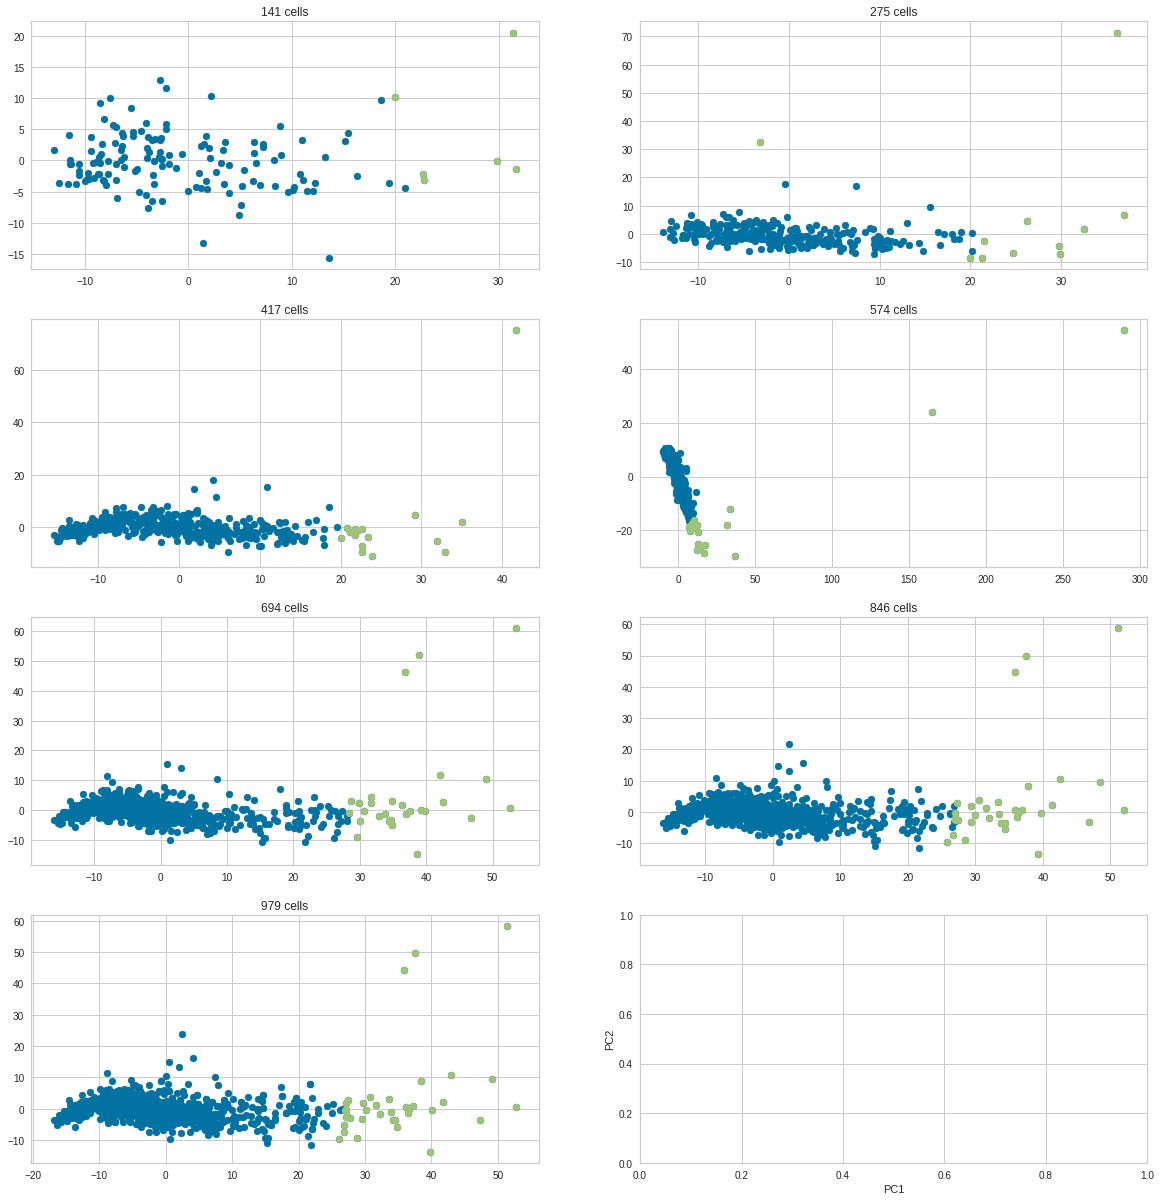

In [ ]:
#@title
#drawing cluster plot for all files
n = 0
a = 0
b = 0
outliers_list = []
fig, axs = plt.subplots(4, 2, figsize=(20,21))

for file in OCSVM_fileList:
  untreatedCells = pd.read_csv(file)
  untreatedCells_PC = untreatedCells.iloc[:, 1:3]

  #Initialize the class object
  kmeans = KMeans(n_clusters= 1)

  #predict the labels of clusters.
  label = kmeans.fit_predict(untreatedCells_PC)

  # obtaining the centers of the clusters
  centroids = kmeans.cluster_centers_
  # points array will be used to reach the index easy
  points = np.empty((0,len(untreatedCells_PC.iloc[0])))
  # distances will be used to calculate outliers
  distances = np.empty((0,len(untreatedCells_PC.iloc[0])), float)
  # getting points and distances
  for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],untreatedCells_PC[label == i], 'euclidean'))
    points = np.append(points, untreatedCells_PC[label == i], axis=0)

  percentile = 96
  # getting outliers whose distances are greater than some percentile
  outliers = points[np.where(distances > np.percentile(distances, percentile))]

  outliers_list.append(outliers)

  #filter rows of original data
  filtered_label0 = untreatedCells_PC[label == 0]

  #plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1])
  axs[a, b].scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1])
  axs[a, b].set_title(totalCellsNum[n] +  ' cells')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  axs[a, b].scatter((*zip(*outliers)), marker="o");

  if (b == 0):
    b = 1
  else:
    a += 1
    b = 0

  n += 1

Outlier removal: https://medium.datadriveninvestor.com/outlier-detection-with-k-means-clustering-in-python-ee3ac1826fb0

In [ ]:
#@title
#CODE FOR MULTIPLE K MEANS PLOT
fig, axs = plt.subplots(4, 2, figsize=(20,21))

#Initialize the class object
kmeans = KMeans(n_clusters= 2)

#predict the labels of clusters.
#label = kmeans.fit_predict(OCSVM_untreated_data1_kmeans)

#filter rows of original data
#filtered_label0 = OCSVM_untreated_data1_kmeans[label == 0]
#filtered_label1 = OCSVM_untreated_data1_kmeans[label == 1]

#Plotting the results
#plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1] , color = 'red')
#plt.scatter(filtered_label1.iloc[:,0] , filtered_label1.iloc[:,1] , color = 'black')

#predict the labels of clusters.
label0 = kmeans.fit_predict(OCSVM_untreated_data1_kmeans)
filtered_label0 = OCSVM_untreated_data1_kmeans[label0 == 0]
filtered_label1 = OCSVM_untreated_data1_kmeans[label0 == 1]
axs[0, 0].scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1],  color = 'red')
axs[0, 0].scatter(filtered_label1.iloc[:,0] , filtered_label1.iloc[:,1],  color = 'black')
axs[0, 0].set_title('141 cells')
plt.xlabel('PC1')
plt.ylabel('PC2')

label1 = kmeans.fit_predict(OCSVM_untreated_data2_kmeans)
filtered_label2 = OCSVM_untreated_data2_kmeans[label1 == 0]
filtered_label3 = OCSVM_untreated_data2_kmeans[label1 == 1]
axs[0, 1].scatter(filtered_label2.iloc[:,0] , filtered_label2.iloc[:,1],  color = 'red')
axs[0, 1].scatter(filtered_label3.iloc[:,0] , filtered_label3.iloc[:,1],  color = 'black')
axs[0, 1].set_title('275 cells')

label2 = kmeans.fit_predict(OCSVM_untreated_data3_kmeans)
filtered_label4 = OCSVM_untreated_data3_kmeans[label2 == 0]
filtered_label5 = OCSVM_untreated_data3_kmeans[label2 == 1]
axs[1, 0].scatter(filtered_label4.iloc[:,0] , filtered_label4.iloc[:,1],  color = 'red')
axs[1, 0].scatter(filtered_label5.iloc[:,0] , filtered_label5.iloc[:,1],  color = 'black')
axs[1, 0].set_title('417 cells')

label3 = kmeans.fit_predict(OCSVM_untreated_data4_kmeans)
filtered_label5 = OCSVM_untreated_data4_kmeans[label3 == 0]
filtered_label6 = OCSVM_untreated_data4_kmeans[label3 == 1]
axs[1, 1].scatter(filtered_label5.iloc[:,0] , filtered_label5.iloc[:,1],  color = 'red')
axs[1, 1].scatter(filtered_label6.iloc[:,0] , filtered_label6.iloc[:,1],  color = 'black')
axs[1, 1].set_title('574 cells')

label4 = kmeans.fit_predict(OCSVM_untreated_data5_kmeans)
filtered_label7 = OCSVM_untreated_data5_kmeans[label4 == 0]
filtered_label8 = OCSVM_untreated_data5_kmeans[label4 == 1]
axs[2, 0].scatter(filtered_label7.iloc[:,0] , filtered_label7.iloc[:,1],  color = 'red')
axs[2, 0].scatter(filtered_label8.iloc[:,0] , filtered_label8.iloc[:,1],  color = 'black')
axs[2, 0].set_title('694 cells')

label5 = kmeans.fit_predict(OCSVM_untreated_data6_kmeans)
filtered_label9 = OCSVM_untreated_data6_kmeans[label5 == 0]
filtered_label10 = OCSVM_untreated_data6_kmeans[label5 == 1]
axs[2, 1].scatter(filtered_label9.iloc[:,0] , filtered_label9.iloc[:,1],  color = 'red')
axs[2, 1].scatter(filtered_label10.iloc[:,0] , filtered_label10.iloc[:,1],  color = 'black')
axs[2, 1].set_title('694 cells')

label6 = kmeans.fit_predict(OCSVM_untreated_data7_kmeans)
filtered_label11 = OCSVM_untreated_data7_kmeans[label6 == 0]
filtered_label12 = OCSVM_untreated_data7_kmeans[label6 == 1]
axs[3, 0].scatter(filtered_label11.iloc[:,0] , filtered_label11.iloc[:,1],  color = 'red')
axs[3, 0].scatter(filtered_label12.iloc[:,0] , filtered_label12.iloc[:,1],  color = 'black')
axs[3, 0].set_title('974 cells')


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


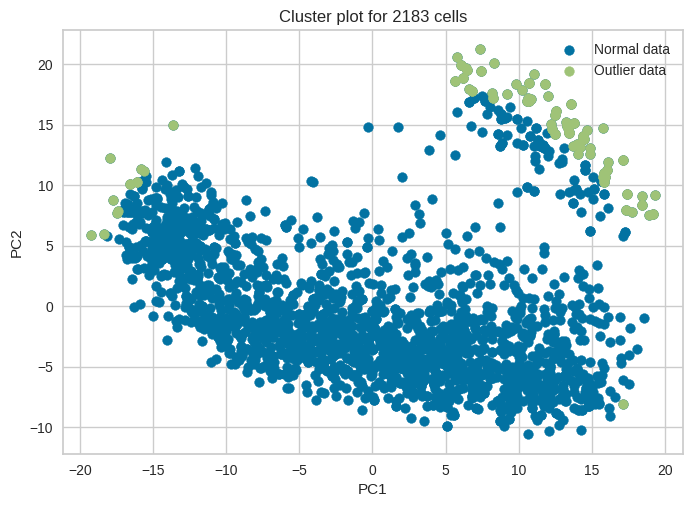

110

In [ ]:
outliers1 = Kmeans_plot(trainPCA.iloc[:, 0:2])
len(outliers1)

In [ ]:
#@title
untreatedCells_2136 = untreatedCells_2136.iloc[:, 1:3]

#Initialize the class object
kmeans = KMeans(n_clusters= 1)
#predict the labels of clusters.
label = kmeans.fit_predict(untreatedCells_2136)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#@title
# obtaining the centers of the clusters
centroids = kmeans.cluster_centers_
# points array will be used to reach the index easy
points = np.empty((0,len(untreatedCells_2136.iloc[0])))
# distances will be used to calculate outliers
distances = np.empty((0,len(untreatedCells_2136.iloc[0])), float)
# getting points and distances
for i, center_elem in enumerate(centroids):
  # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],untreatedCells_2136[label == i], 'euclidean'))
    points = np.append(points, untreatedCells_2136[label == i], axis=0)

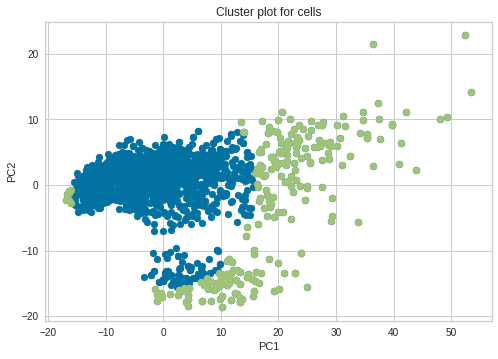

In [ ]:
#@title
percentile = 87
# getting outliers whose distances are greater than some percentile
outliers = points[np.where(distances > np.percentile(distances, percentile))]

#outliers_list.append(outliers)

#filter rows of original data
filtered_label0 = untreatedCells_2136[label == 0]

#plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1])
plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1])
plt.title("Cluster plot for cells")
plt.xlabel('PC1')
plt.ylabel('PC2')
x,y = zip(*outliers)
#print(x)
plt.scatter(x, y, marker="o")

plt.show()
  #return outliers

In [ ]:
trainPCA_new = removeOutliers(outliers1, trainPCA)
trainPCA_new

,PC1,PC2,Label
0,-13.518923,0.064746,cell
1,-11.154316,1.755943,cell
2,-10.981773,-0.925905,cell
3,7.281225,-3.819778,cell
4,-2.652113,-1.238341,cell
...,...,...,...
2178,6.979500,-1.826601,cell
2180,-15.501442,6.456234,cell
2181,-8.676543,8.769503,cell
2182,-11.803223,4.626240,cell


Export PCA  (if needed)

In [ ]:
# export the DataFrame as an Excel file
untreatedCells_2006.to_excel('untreatedCells_2006_new.xlsx', index=False)

# download the Excel file to your local machine
files.download('data.xlsx')

## **6.6 Train, Validation, Test split**

Train data

In [ ]:
trainPCA_new['Label'] = trainPCA_new['Label'].replace({'cell': 1})
trainPCA_new

,PC1,PC2,Label
0,-13.518923,0.064746,1
1,-11.154316,1.755943,1
2,-10.981773,-0.925905,1
3,7.281225,-3.819778,1
4,-2.652113,-1.238341,1
...,...,...,...
2178,6.979500,-1.826601,1
2180,-15.501442,6.456234,1
2181,-8.676543,8.769503,1
2182,-11.803223,4.626240,1


In [ ]:
train_untreated['Label'] = train_untreated['Label'].replace({'cell': 1})
train_untreated

,0,1,2,3,4,5,6,7,8,9,...,943,944,945,946,947,948,949,950,951,Label
0,0.040042,0.038932,0.037000,0.034395,0.031267,0.027768,0.024045,0.020248,0.016528,0.013033,...,0.000154,-0.000254,-0.000257,0.000145,0.000952,0.002165,0.003785,0.005812,0.008247,1
1,0.042402,0.036243,0.030548,0.025329,0.020598,0.016367,0.012648,0.009453,0.006793,0.004680,...,0.039819,0.044771,0.048150,0.049287,0.047510,0.042148,0.032527,0.017977,-0.002176,1
2,-0.002602,0.015080,0.028752,0.038837,0.045757,0.049933,0.051787,0.051740,0.050212,0.047626,...,0.048259,0.053900,0.057594,0.058576,0.056081,0.049344,0.037599,0.020082,-0.003975,1
3,0.027801,0.035414,0.039957,0.041805,0.041334,0.038920,0.034939,0.029764,0.023771,0.017334,...,0.030224,0.030383,0.029612,0.027782,0.024763,0.020428,0.014647,0.007291,-0.001770,1
4,0.035702,0.029399,0.025269,0.023017,0.022348,0.022966,0.024577,0.026885,0.029595,0.032411,...,0.038979,0.040625,0.041073,0.039946,0.036866,0.031454,0.023332,0.012122,-0.002555,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,-0.002030,0.013712,0.026119,0.035522,0.042251,0.046639,0.049014,0.049708,0.049051,0.047371,...,0.003342,-0.000157,-0.001653,-0.000626,0.003444,0.011079,0.022799,0.039125,0.060579,1
2180,0.106451,0.078365,0.057214,0.042228,0.032638,0.027673,0.026563,0.028537,0.032826,0.038659,...,0.031419,0.038590,0.045233,0.050945,0.055324,0.057968,0.058475,0.056441,0.051462,1
2181,-0.003085,0.018507,0.034911,0.046674,0.054343,0.058467,0.059592,0.058265,0.055032,0.050440,...,0.007096,0.007282,0.007857,0.008689,0.009646,0.010594,0.011400,0.011932,0.012057,1
2182,-0.004460,0.009199,0.020233,0.028901,0.035461,0.040172,0.043292,0.045079,0.045790,0.045684,...,0.044528,0.042535,0.041004,0.040403,0.041205,0.043878,0.048892,0.056717,0.067821,1


In [ ]:
#@title
#splitting dataset to dependent and independent variable
#X_train = trainPCA_new.iloc[:,0:-1] #independent values / features
#y_train = trainPCA_new.iloc[:,-1] #dependent values / target

X_train = train_untreated.iloc[:,0:-1] #independent values / features
y_train = train_untreated.iloc[:,-1] #dependent values / target

Validation data

In [ ]:
val_untreated['Label'] = val_untreated['Label'].replace({'untreated': 1})
val_untreated

,0,1,2,3,4,5,6,7,8,9,...,943,944,945,946,947,948,949,950,951,Label
0,0.045423,0.035261,0.026554,0.019220,0.013179,0.008349,0.004650,0.001999,0.000316,-0.000480,...,0.038903,0.042983,0.045329,0.045473,0.042947,0.037284,0.028015,0.014673,-0.003212,1
1,0.059155,0.042059,0.028316,0.017628,0.009694,0.004214,0.000890,-0.000580,-0.000494,0.000847,...,0.017625,0.018504,0.018997,0.019064,0.018670,0.017777,0.016348,0.014346,0.011732,1
2,0.027216,0.026979,0.027435,0.028438,0.029837,0.031487,0.033238,0.034942,0.036451,0.037615,...,0.018890,0.018395,0.017356,0.015753,0.013565,0.010773,0.007357,0.003295,-0.001431,1
3,0.014304,0.014918,0.015114,0.014938,0.014438,0.013660,0.012651,0.011458,0.010127,0.008705,...,0.024015,0.022949,0.021433,0.019395,0.016761,0.013458,0.009415,0.004557,-0.001187,1
4,0.054044,0.046849,0.040779,0.035716,0.031542,0.028139,0.025390,0.023175,0.021375,0.019873,...,0.017858,0.018979,0.020123,0.021354,0.022733,0.024323,0.026187,0.028386,0.030984,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0.077101,0.065140,0.054773,0.045878,0.038334,0.032018,0.026809,0.022583,0.019219,0.016594,...,0.016506,0.017715,0.018340,0.018191,0.017080,0.014816,0.011210,0.006073,-0.000784,1
207,0.024701,0.020013,0.015705,0.011821,0.008406,0.005506,0.003164,0.001424,0.000333,-0.000066,...,0.013444,0.011455,0.009425,0.007392,0.005395,0.003473,0.001665,0.000010,-0.001452,1
208,0.054349,0.039934,0.028129,0.018710,0.011455,0.006141,0.002544,0.000441,-0.000391,-0.000174,...,0.012207,0.015277,0.017897,0.019833,0.020853,0.020721,0.019202,0.016063,0.011069,1
209,0.055834,0.045453,0.038232,0.033770,0.031665,0.031518,0.032928,0.035492,0.038811,0.042482,...,0.050687,0.053186,0.053787,0.052116,0.047799,0.040463,0.029734,0.015235,-0.003406,1


In [ ]:
#@title
#splitting dataset to dependent and independent variable
X_val = val_untreated.iloc[:,0:-1] #independent values / features
y_val = val_untreated.iloc[:,-1] #dependent values / target

Test data

In [ ]:
test_treated['Label'] = test_treated['Label'].replace({'treated': 0})
test_treated

,0,1,2,3,4,5,6,7,8,9,...,943,944,945,946,947,948,949,950,951,Label
0,-0.000930,0.023384,0.041443,0.053879,0.061325,0.064413,0.063775,0.060041,0.053843,0.045812,...,0.050908,0.054645,0.056443,0.055777,0.052119,0.044942,0.033719,0.017922,-0.002977,0
1,0.032409,0.020100,0.010890,0.004476,0.000554,-0.001181,-0.001032,0.000698,0.003708,0.007695,...,0.037110,0.032245,0.027062,0.021705,0.016318,0.011043,0.006025,0.001407,-0.002668,0
2,0.085304,0.081044,0.077036,0.073290,0.069815,0.066621,0.063717,0.061112,0.058814,0.056831,...,0.014189,0.010411,0.007032,0.004156,0.001887,0.000330,-0.000412,-0.000235,0.000966,0
3,0.011381,0.021305,0.029309,0.035519,0.040063,0.043068,0.044660,0.044966,0.044112,0.042223,...,0.035701,0.038685,0.040875,0.042020,0.041871,0.040176,0.036686,0.031150,0.023316,0
4,0.079221,0.068543,0.058042,0.047868,0.038171,0.029101,0.020806,0.013437,0.007141,0.002069,...,0.002627,-0.000454,-0.001609,-0.000303,0.004003,0.011847,0.023768,0.040302,0.061990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,0.074533,0.066157,0.058512,0.051548,0.045217,0.039467,0.034251,0.029517,0.025216,0.021297,...,0.016152,0.017224,0.018040,0.018546,0.018686,0.018406,0.017650,0.016362,0.014487,0
170,0.054986,0.066316,0.073263,0.076344,0.076078,0.072982,0.067571,0.060364,0.051876,0.042622,...,0.006642,0.012146,0.017655,0.022765,0.027072,0.030172,0.031662,0.031137,0.028193,0
171,0.039763,0.030152,0.022999,0.018051,0.015055,0.013757,0.013904,0.015241,0.017516,0.020474,...,0.031855,0.035770,0.038275,0.038899,0.037174,0.032629,0.024794,0.013200,-0.002624,0
172,0.042594,0.030327,0.022080,0.017331,0.015559,0.016241,0.018857,0.022885,0.027802,0.033087,...,0.018825,0.017531,0.016139,0.014508,0.012492,0.009950,0.006737,0.002709,-0.002276,0


In [ ]:
#splitting dataset to dependent and independent variable
X_test = test_treated.iloc[:,0:-1] #independent values / features
y_test = test_treated.iloc[:,-1] #dependent values / target

## **6.7 One Class SVM (OCSVM)**






Import libraries

In [ ]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Train model with untreated cells and evaluate model with untreated cells (training and validation data)

In [ ]:
# Train the one class support vector machine (SVM) model
one_class_svm_untreated = OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5).fit(X_train)

NameError: ignored

In [ ]:
# Predict the anomalies
y_val_pred = one_class_svm_untreated.predict(X_val)
# Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
#during prediction, -1 means anomaly, change it to 0
y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]
#mix_pred_label
# Check the model performance
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.62      0.76       211

    accuracy                           0.62       211
   macro avg       0.50      0.31      0.38       211
weighted avg       1.00      0.62      0.76       211



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_val_pred

[1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming y_true and y_pred are the true and predicted labels respectively
accuracy = accuracy_score(y_val, y_val_pred)
accuracy_percent = accuracy * 100

print(accuracy_percent)

61.61137440758294


VALIDATION

In [ ]:
OCSVM_file8 = "/content/drive/MyDrive/Processed untreated cells for oneClass SVM validation/211 untreated val cells (20 Feb)-SigProc-PCs.csv"
OCSVM_untreated_data2 = pd.read_csv(OCSVM_file8)

In [ ]:
OCSVM_untreated_data2 = OCSVM_untreated_data2.iloc[:, 1:]

In [ ]:
testPCA['Label'] = testPCA['Label'].replace({'untreated': 1})
testPCA

,PC1,PC2,Label
0,-2143.332958,1522.972586,1
1,-2143.141889,1522.983629,1
2,-2142.756827,1523.513402,1
3,-2143.313536,1523.066922,1
4,-2141.242307,1523.210034,1
...,...,...,...
206,-2143.012295,1522.648131,1
207,-2141.616420,1524.761772,1
208,-2143.040029,1522.832464,1
209,-2143.246579,1523.008903,1


In [ ]:
#splitting dataset to dependent and independent variable
X_val = testPCA.iloc[:,0:-1] #independent values / features
y_val = testPCA.iloc[:,-1] #dependent values / target

TREATED CELLS

In [ ]:
OCSVM_file6 = "/content/drive/MyDrive/20221109_p6hMSC_treated cell samples_0p5PG-AlgMS-SigProc-PCs.csv"

In [ ]:
OCSVM_file6 = "/content/drive/MyDrive/20230111_p6hMSC_1-SigProc-PCs.csv"

In [ ]:
OCSVM_treated_data = pd.read_csv(OCSVM_file6)

In [ ]:
OCSVM_treated_data

,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,Label
0,0,-2.445131,4.466012,0.416967,-0.986513,3.092416,cell
1,1,-2.956207,-2.077062,1.302232,0.526723,-0.928429,cell
2,2,-3.123598,-0.153676,-0.593937,2.303806,-0.510084,cell
3,3,-5.588725,-0.754851,1.627246,-0.986436,2.004076,cell
4,4,-4.755104,-1.056147,-1.562331,0.584955,-3.962674,cell
...,...,...,...,...,...,...,...
235,235,-6.881365,0.587980,1.943127,-1.249075,1.069859,cell
236,236,-5.973122,-0.663103,1.344349,-0.642965,2.250086,cell
237,237,7.413097,8.911179,-4.004038,-1.376496,3.014737,cell
238,238,-2.376233,4.777487,0.373669,-2.031561,2.131699,cell


In [ ]:
#splitting dataset to dependent and independent variable
X_test = OCSVM_treated_data.iloc[:,1:-1] #independent values / features
y_test = OCSVM_treated_data.iloc[:,-1] #dependent values / target

In [ ]:
X_test

,PC1,PC2,PC3,PC4,PC5
0,-2.445131,4.466012,0.416967,-0.986513,3.092416
1,-2.956207,-2.077062,1.302232,0.526723,-0.928429
2,-3.123598,-0.153676,-0.593937,2.303806,-0.510084
3,-5.588725,-0.754851,1.627246,-0.986436,2.004076
4,-4.755104,-1.056147,-1.562331,0.584955,-3.962674
...,...,...,...,...,...
235,-6.881365,0.587980,1.943127,-1.249075,1.069859
236,-5.973122,-0.663103,1.344349,-0.642965,2.250086
237,7.413097,8.911179,-4.004038,-1.376496,3.014737
238,-2.376233,4.777487,0.373669,-2.031561,2.131699


## **6.8 Quantifying Cell viability using Pyrogallol-treated hMSCs (testing data)**

In [ ]:
# Predict the anomalies
y_test_pred = one_class_svm_untreated.predict(X_test)
# Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
#during prediction, -1 means anomaly, change it to 0
y_test_pred = [0 if i==-1 else 1 for i in y_test_pred]

In [ ]:
cell_viability = ((np.count_nonzero(y_test_pred))/len(y_test_pred)) * 100
print(cell_viability)

37.93103448275862


## **6.9 Train model with increasing untreated cells and evaluate model with untreated cells (training and validation data)**

In [ ]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
from random import sample

#sample_size = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2180]
sample_size = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

In [ ]:
Sample_train = train_untreated.iloc[:, 1:-1]
#Sample_train = train_untreated_trunc
val_untreated['Label'] = val_untreated['Label'].replace({'untreated': 1})

Sample_val = val_untreated.iloc[:, 1:-1]
#Sample_val = val_untreated_trunc
#Sample_test = test_treated.iloc[:, 1:-1]

dataLabel1 = np.array(train_untreated.iloc[:, -1])
dataLabel2 = np.array(val_untreated.iloc[:, -1])
#dataLabel3 = np.array(test_treated.iloc[:, -1])

principalComponentsNum = 2
pca = PCA(n_components=principalComponentsNum)

In [ ]:
Sample_val

,1,2,3,4,5,6,7,8,9,10,...,942,943,944,945,946,947,948,949,950,951
0,1110,1099,1087,1067,1088,1085,1102,1081,1084,1082,...,952,956,948,949,963,931,950,953,943,964
1,1151,1139,1135,1133,1142,1140,1134,1147,1127,1129,...,976,968,967,968,978,959,955,953,955,966
2,1328,1323,1313,1298,1317,1294,1303,1316,1288,1325,...,1024,1018,1026,1014,1030,1001,1019,1014,1001,1025
3,1314,1315,1293,1324,1310,1322,1311,1312,1295,1314,...,1021,1025,1012,1022,1013,997,1018,1018,999,1022
4,1289,1275,1282,1290,1290,1256,1280,1276,1259,1278,...,1010,1010,1019,1006,1009,990,1015,1012,992,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,1298,1310,1289,1293,1299,1303,1294,1293,1288,1276,...,1025,1010,1009,1014,1015,995,1011,1015,1005,1014
207,1351,1332,1317,1330,1338,1320,1323,1332,1309,1331,...,1034,1018,1027,1030,1028,989,1027,1006,1018,1017
208,1264,1267,1242,1257,1253,1264,1257,1257,1268,1266,...,993,992,998,990,1013,984,998,999,985,989
209,1368,1370,1327,1351,1349,1335,1348,1345,1337,1357,...,1029,1036,1029,1028,1029,1010,1021,1012,1011,1041


In [ ]:
mega_results = {}

### a. Loop for ORIGINAL Preprocess Data

In [ ]:
acc_result1 = []

for size in sample_size:

  X_train1 = Sample_train.sample(n = size)

  # Train the one class support vector machine (SVM) model
  one_class_svm_untreated = OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5).fit(X_train1)

  # Predict the anomalies
  y_val_pred = one_class_svm_untreated.predict(Sample_val)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]

  # Assuming y_true and y_pred are the true and predicted labels respectively
  accuracy = accuracy_score(dataLabel2, y_val_pred)
  accuracy_percent = accuracy * 100
  print(accuracy_percent)

  # Check the model performance
  #print(classification_report(y_val, y_val_pred))

  acc_result1.append(accuracy_percent)


display_results = pd.DataFrame(acc_result1)
display_results

83.88625592417061
86.25592417061611
85.30805687203792
88.62559241706161
87.67772511848341
87.20379146919431
88.62559241706161
87.20379146919431
86.7298578199052
88.15165876777252


,0
0,83.886256
1,86.255924
2,85.308057
3,88.625592
4,87.677725
5,87.203791
6,88.625592
7,87.203791
8,86.729858
9,88.151659


### b. Loop for ORIGINAL Preprocess Data + PCA

In [ ]:
acc_result2 = []
via_result2 = []

for size in sample_size:

  X_train1 = Sample_train.sample(n = size)

  #Need to SCALE on train data
  scaler = StandardScaler()
  Sample_train_scaled_fit = scaler.fit(X_train1)

  #perform PCA on train data data
  Sample_train_pca_fit = pca.fit(X_train1)

  #Transform using SCALING PARAMETERS on train data
  Sample_train1_scaled = Sample_train_scaled_fit.transform(X_train1)
  #Transform using PCA PARAMETERS on train data
  SampleTrain1 = Sample_train_pca_fit.transform(Sample_train1_scaled)

  #Transform using SCALING PARAMETERS ON val data
  Sample_val1_scaled = Sample_train_scaled_fit.transform(Sample_val)
  #Transform using PCA PARAMETERS on test data
  SampleVal = Sample_train_pca_fit.transform(Sample_val1_scaled)

  SampleTrain1 = pd.DataFrame(SampleTrain1, columns=['PC1', 'PC2'])
  #SampleTrain1['Label'] = dataLabel1

  SampleVal = pd.DataFrame(SampleVal, columns=['PC1', 'PC2'])
  SampleVal['Label'] = dataLabel2
  X_val = SampleVal.iloc[:, 0:-1]
  y_val = SampleVal.iloc[:, -1]

  # Train the one class support vector machine (SVM) model
  one_class_svm_untreated = OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5).fit(SampleTrain1)

  # Predict the anomalies
  y_val_pred = one_class_svm_untreated.predict(X_val)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]

  # Assuming y_true and y_pred are the true and predicted labels respectively
  accuracy = accuracy_score(y_val, y_val_pred)
  accuracy_percent = accuracy * 100
  via_result2.append(accuracy_percent)


  # Check the model performance
  #print(classification_report(y_val, y_val_pred))

  acc_result2.append(accuracy_percent)
display_results = pd.DataFrame(acc_result2)
display_results

display_viaResults = pd.DataFrame(via_result2)
display_viaResults
  #mega_results['Original Preprocessed Data + PCA'] = acc_result2

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


91.9431279620853
93.36492890995261


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


91.4691943127962


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


90.52132701421802


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


92.89099526066352


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


90.52132701421802


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


90.99526066350711


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


90.99526066350711


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


91.4691943127962


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


91.4691943127962


,0
0,91.943128
1,93.364929
2,91.469194
3,90.521327
4,92.890995
5,90.521327
6,90.995261
7,90.995261
8,91.469194
9,91.469194


In [ ]:
valPCA

,PC1,PC2,Label
0,12.511695,-5.768060,1
1,15.369328,-6.838304,1
2,13.304833,-7.022212,1
3,13.411821,-5.653167,1
4,15.986657,-7.324917,1
...,...,...,...
206,13.205962,-5.456459,1
207,12.364851,-6.917062,1
208,16.613742,-7.744348,1
209,5.460220,-4.426715,1


In [ ]:
acc_result2 = []
y_val = valPCA.iloc[:, -1]

for size in sample_size:

  X_train1 = trainPCA_new.sample(n = size)


  # Train the one class support vector machine (SVM) model
  one_class_svm_untreated = OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5).fit(X_train1.iloc[:, :-1])

  # Predict the anomalies
  y_val_pred = one_class_svm_untreated.predict(valPCA.iloc[:, :-1])
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]

  # Assuming y_true and y_pred are the true and predicted labels respectively
  accuracy = accuracy_score(y_val, y_val_pred)
  accuracy_percent = accuracy * 100
  print(accuracy_percent)

  # Check the model performance
  #print(classification_report(y_val, y_val_pred))

  acc_result2.append(accuracy_percent)

display_results = pd.DataFrame(acc_result2)
display_results

44.54976303317535
59.241706161137444
56.872037914691944
45.497630331753555
48.34123222748815
51.18483412322274
51.65876777251185
47.867298578199055
50.71090047393365
50.71090047393365


,0
0,44.549763
1,59.241706
2,56.872038
3,45.497630
4,48.341232
5,51.184834
6,51.658768
7,47.867299
8,50.710900
9,50.710900


### c. Loop for 4 wavelength Preprocess Data

In [ ]:
acc_result3 = []

for size in sample_size:

  X_train1 = Sample_train.sample(n = size)

  # Train the one class support vector machine (SVM) model
  one_class_svm_untreated = OneClassSVM(kernel='poly', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5).fit(X_train1)

  # Predict the anomalies
  y_val_pred = one_class_svm_untreated.predict(Sample_val)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]

  # Assuming y_true and y_pred are the true and predicted labels respectively
  accuracy = accuracy_score(dataLabel2, y_val_pred)
  accuracy_percent = accuracy * 100
  print(accuracy_percent)

  # Check the model performance
  #print(classification_report(y_val, y_val_pred))

  acc_result3.append(accuracy_percent)
  #mega_results['4 wavelength Preprocessed Data'] = acc_result3

display_results = pd.DataFrame(acc_result3)
display_results

59.71563981042654
62.55924170616114
63.98104265402843
63.98104265402843
62.55924170616114
63.98104265402843
63.03317535545023
63.98104265402843
62.55924170616114
63.03317535545023


,0
0,59.715640
1,62.559242
2,63.981043
3,63.981043
4,62.559242
5,63.981043
6,63.033175
7,63.981043
8,62.559242
9,63.033175


### d. Loop for 4 wavelength Preprocess Data + PCA

In [ ]:
acc_result4 = []
via_result4 = []

for size in sample_size:

  X_train1 = Sample_train.sample(n = size)

  #Need to SCALE on train data
  scaler = StandardScaler()
  Sample_train_scaled_fit = scaler.fit(X_train1)

  #perform PCA on train data data
  Sample_train_pca_fit = pca.fit(X_train1)

  #Transform using SCALING PARAMETERS on train data
  Sample_train1_scaled = Sample_train_scaled_fit.transform(X_train1)
  #Transform using PCA PARAMETERS on train data
  SampleTrain1 = Sample_train_pca_fit.transform(Sample_train1_scaled)

  #Transform using SCALING PARAMETERS ON val data
  Sample_val1_scaled = Sample_train_scaled_fit.transform(Sample_val)
  #Transform using PCA PARAMETERS on val data
  SampleVal = Sample_train_pca_fit.transform(Sample_val1_scaled)

  #Transform using SCALING PARAMETERS ON TEST data
  Sample_test1_scaled = Sample_train_scaled_fit.transform(Sample_test)
  #Transform using PCA PARAMETERS on TEST data
  SampleTest = Sample_train_pca_fit.transform(Sample_test1_scaled)

  SampleTrain1 = pd.DataFrame(SampleTrain1, columns=['PC1', 'PC2'])
  #SampleTrain1['Label'] = dataLabel1

  SampleVal = pd.DataFrame(SampleVal, columns=['PC1', 'PC2'])
  SampleVal['Label'] = dataLabel2
  X_val = SampleVal.iloc[:, 0:-1]
  y_val = SampleVal.iloc[:, -1]

  SampleTest = pd.DataFrame(SampleTest, columns=['PC1', 'PC2'])
  SampleTest['Label'] = dataLabel3
  X_test = SampleTest.iloc[:, 0:-1]

  # Train the one class support vector machine (SVM) model
  one_class_svm_untreated = OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5).fit(SampleTrain1)

  # Predict the anomalies
  y_val_pred = one_class_svm_untreated.predict(X_val)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]

  # Assuming y_true and y_pred are the true and predicted labels respectively
  accuracy = accuracy_score(y_val, y_val_pred)
  accuracy_percent = accuracy * 100
  print(accuracy_percent)

  # Check the model performance
  #print(classification_report(y_val, y_val_pred))

  acc_result4.append(accuracy_percent)
  #mega_results['4 wavelength Preprocessed Data + PCA'] = acc_result4

  # Predict the anomalies - TEST
  y_test_pred = one_class_svm_untreated.predict(X_test)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_test_pred = [0 if i==-1 else 1 for i in y_test_pred]

  cell_viability = ((np.count_nonzero(y_test_pred))/len(y_test_pred)) * 100
  print(cell_viability)

  via_result4.append(cell_viability)

display_results = pd.DataFrame(acc_result4)
display_results

display_viaResults = pd.DataFrame(via_result4)
display_viaResults

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: ignored

### e. Loop for Original Proprocess Data + Truncation

In [ ]:
acc_result5 = []
via_result5 = []

for size in sample_size:

  X_train1 = Sample_train.sample(n = size)
  X_test = Sample_test

  # Train the one class support vector machine (SVM) model
  one_class_svm_untreated = OneClassSVM(kernel='poly', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5).fit(X_train1)

  # Predict the anomalies
  y_val_pred = one_class_svm_untreated.predict(Sample_val)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]

  # Assuming y_true and y_pred are the true and predicted labels respectively
  accuracy = accuracy_score(dataLabel2, y_val_pred)
  accuracy_percent = accuracy * 100
  print(accuracy_percent)

  # Check the model performance
  #print(classification_report(y_val, y_val_pred))

  acc_result5.append(accuracy_percent)
  #mega_results['Original Preprocessed Data w/o Truncation'] = acc_result5

  # Predict the anomalies - TEST
  y_test_pred = one_class_svm_untreated.predict(X_test)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_test_pred = [0 if i==-1 else 1 for i in y_test_pred]

  cell_viability = ((np.count_nonzero(y_test_pred))/len(y_test_pred)) * 100
  print(cell_viability)

  via_result5.append(cell_viability)


display_results = pd.DataFrame(acc_result5)
display_results

display_viaResults = pd.DataFrame(via_result5)
display_viaResults

95.260663507109
60.256410256410255
98.5781990521327
97.43589743589743
98.5781990521327
97.43589743589743
96.6824644549763
58.97435897435898
98.5781990521327
97.43589743589743
98.5781990521327
98.71794871794873
98.5781990521327
98.71794871794873
98.5781990521327
98.71794871794873
98.5781990521327
98.71794871794873
98.5781990521327
98.71794871794873


,0
0,60.256410
1,97.435897
2,97.435897
3,58.974359
4,97.435897
5,98.717949
6,98.717949
7,98.717949
8,98.717949
9,98.717949


### f. Loop for Original preprocess of Data + Truncation + PCA

In [ ]:
acc_result6 = []

for size in sample_size:

  X_train1 = Sample_train.sample(n = size)

  #Need to SCALE on train data
  scaler = StandardScaler()
  Sample_train_scaled_fit = scaler.fit(X_train1)

  #perform PCA on train data data
  Sample_train_pca_fit = pca.fit(X_train1)

  #Transform using SCALING PARAMETERS on train data
  Sample_train1_scaled = Sample_train_scaled_fit.transform(X_train1)
  #Transform using PCA PARAMETERS on train data
  SampleTrain1 = Sample_train_pca_fit.transform(Sample_train1_scaled)

  #Transform using SCALING PARAMETERS ON val data
  Sample_val1_scaled = Sample_train_scaled_fit.transform(Sample_val)
  #Transform using PCA PARAMETERS on test data
  SampleVal = Sample_train_pca_fit.transform(Sample_val1_scaled)

  SampleTrain1 = pd.DataFrame(SampleTrain1, columns=['PC1', 'PC2'])
  #SampleTrain1['Label'] = dataLabel1

  SampleVal = pd.DataFrame(SampleVal, columns=['PC1', 'PC2'])
  SampleVal['Label'] = dataLabel2
  X_val = SampleVal.iloc[:, 0:-1]
  y_val = SampleVal.iloc[:, -1]

  # Train the one class support vector machine (SVM) model
  one_class_svm_untreated = OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5).fit(SampleTrain1)

  # Predict the anomalies
  y_val_pred = one_class_svm_untreated.predict(X_val)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]

  # Assuming y_true and y_pred are the true and predicted labels respectively
  accuracy = accuracy_score(y_val, y_val_pred)
  accuracy_percent = accuracy * 100
  print(accuracy_percent)

  # Check the model performance
  #print(classification_report(y_val, y_val_pred))

  acc_result6.append(accuracy_percent)


display_results = pd.DataFrame(acc_result6)
display_results

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


90.04739336492891
92.89099526066352


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


93.8388625592417
92.41706161137441


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


93.8388625592417


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


92.41706161137441


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


92.89099526066352


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


93.36492890995261


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


92.41706161137441


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


91.9431279620853


,0
0,90.047393
1,92.890995
2,93.838863
3,92.417062
4,93.838863
5,92.417062
6,92.890995
7,93.364929
8,92.417062
9,91.943128


### g. Loop for Original RAW data

In [ ]:
acc_result6 = []

for size in sample_size:

  X_train1 = Sample_train.sample(n = size)

  # Train the one class support vector machine (SVM) model
  one_class_svm_untreated = OneClassSVM(kernel='poly', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5).fit(X_train1)

  # Predict the anomalies
  y_val_pred = one_class_svm_untreated.predict(Sample_val)
  # Change the anomalies' values to make it consistent with the true values #in this case, 1 means "good" and 0 means "bad"
  #during prediction, -1 means anomaly, change it to 0
  y_val_pred = [0 if i==-1 else 1 for i in y_val_pred]

  # Assuming y_true and y_pred are the true and predicted labels respectively
  accuracy = accuracy_score(dataLabel2, y_val_pred)
  accuracy_percent = accuracy * 100
  print(accuracy_percent)

  # Check the model performance
  #print(classification_report(y_val, y_val_pred))

  acc_result6.append(accuracy_percent)

display_results = pd.DataFrame(acc_result6)
display_results

83.41232227488152
80.09478672985783
84.83412322274881
82.93838862559242
82.93838862559242
80.09478672985783
81.04265402843602
81.04265402843602
81.51658767772511
81.99052132701422


,0
0,83.412322
1,80.094787
2,84.834123
3,82.938389
4,82.938389
5,80.094787
6,81.042654
7,81.042654
8,81.516588
9,81.990521


## **6.10 Plot all Accuracies**

In [ ]:
mega_results['Original RAW Data']

[41.70616113744076,
 42.18009478672986,
 42.18009478672986,
 44.54976303317535,
 42.65402843601896,
 44.54976303317535,
 44.07582938388626,
 42.65402843601896,
 45.497630331753555,
 45.497630331753555,
 44.07582938388626]

Text(0.5, 1.0, 'Accuracy of model vs increasing training datasets for 6 different data combinations')

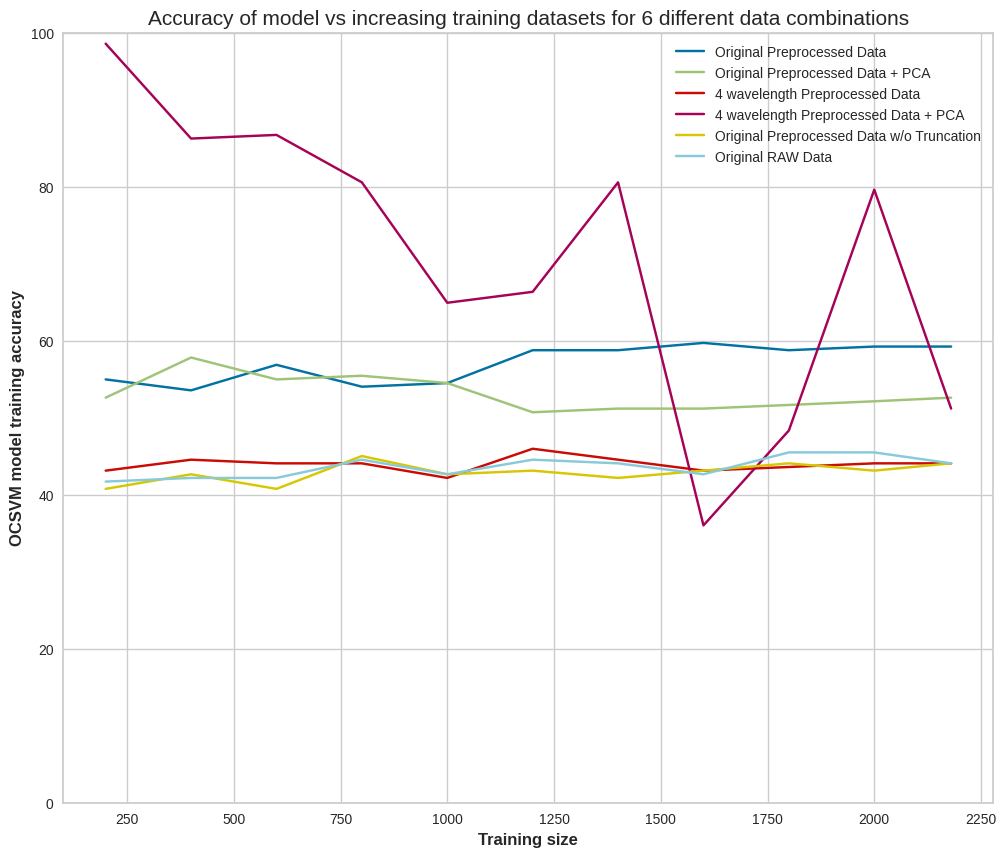

In [ ]:
plt.figure(figsize=(12, 10))

for results in mega_results:
  plt.plot(sample_size, mega_results[results], label = results)

plt.legend()
plt.ylim(0, 100)
plt.xlabel('Training size', fontsize=12, fontweight =  'bold')
plt.ylabel('OCSVM model training accuracy', fontsize=12, fontweight =  'bold')
plt.title("Accuracy of model vs increasing training datasets for 6 different data combinations", fontsize=15)

Text(0.5, 1.0, 'Accuracy of model vs increasing trainng datasets')

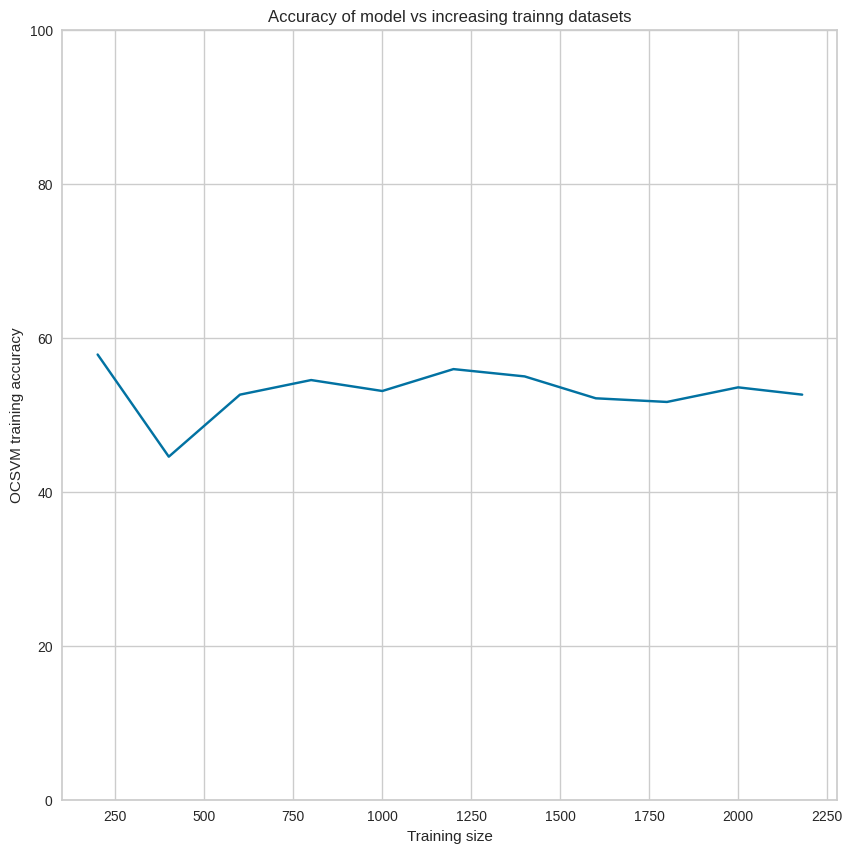

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(sample_size,acc_result2)
plt.ylim(0, 100)
plt.xlabel('Training size')
plt.ylabel('OCSVM training accuracy')
plt.legend()
plt.title("Accuracy of model vs increasing trainng datasets")

do in 2 parts:
1st part: train untreated data and test with untreated data --> to see that the model is accurate
2nd part: use all trained data to test on untreated data --> to check whether the untreated cell are actually viable or not

use % division to check

ideally the untreated data should also be viable and be classified as 'treated'

## **6.11 Hyperparameter Tuning CNN**

In [ ]:
"param_grid = {'filters': [[32, 64, 128, 256], [64, 128, 256, 512]],
              'kernel_size': [(1,1,1,1), (2,2,2,2)],
              'units_1': [100, 200, 300],
              'units_2': [50, 100, 150]}

In [ ]:
def build_model(filters, kernel_size, units_1, units_2):
    model = Sequential()
    model.add(Conv1D(filters=filters[0], kernel_size=kernel_size[0], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape = (X_train.shape[1],1)))
    model.add(Conv1D(filters=filters[1], kernel_size=kernel_size[1], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Conv1D(filters=filters[2], kernel_size=kernel_size[2], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Conv1D(filters=filters[3], kernel_size=kernel_size[3], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

    model.add(Flatten())
    model.add(Dense(units=units_1, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dense(units=units_2, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))

    model.add(Dense(units=2, activation='softmax'))
    model.add(Flatten())
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=build_model, epochs=10, verbose=0)

<ipython-input-28-605686a29717>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, epochs=10, verbose=0)


In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

In [ ]:
grid_result = grid.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
best_model = build_model(**grid_result.best_params_)
best_model.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

In [ ]:
output_layer = model.predict(x=X_test, verbose=0)
np.round(output_layer)

y_pred = np.argmax(output_layer, axis=-1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(11, 11))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '0'], )

disp.plot(cmap =plt.cm.Blues, ax = ax)
plt.show()

print(classification_report(y_test, y_pred, target_names=['1', '0']))

In [ ]:
y_train1 = np.asarray(y_train1).astype('int32').reshape((-1,1))
y_test1 = np.asarray(y_test1).astype('int32').reshape((-1,1))

In [ ]:
y_test1.shape

(30, 1)

In [ ]:
# Initialize model
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Add max pooling layers
model.add(MaxPooling1D(pool_size=2))
model.add(MaxPooling1D(pool_size=2))

# Flatten output and add dropout layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(2, activation='softmax'))
model.add(Flatten())

In [ ]:
# Initialize model
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))


# Flatten output and add dropout layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(2, activation='softmax'))
model.add(Flatten())

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 222, 32)           128       
                                                                 
 conv1d_34 (Conv1D)          (None, 219, 64)           8256      
                                                                 
 conv1d_35 (Conv1D)          (None, 215, 128)          41088     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 107, 128)         0         
 g1D)                                                            
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 53, 128)          0         
 g1D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 6784)            

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit(X_train, y_train, epochs=15, batch_size = 10, validation_data = (X_test, y_test))

Epoch 1/15
23/23 [==============================] - 2s 46ms/step - loss: 1.0466 - accuracy: 0.4554 - val_loss: 0.7229 - val_accuracy: 0.2812
Epoch 2/15
23/23 [==============================] - 1s 35ms/step - loss: 0.8116 - accuracy: 0.5714 - val_loss: 0.7074 - val_accuracy: 0.4375
Epoch 3/15
23/23 [==============================] - 1s 35ms/step - loss: 0.7329 - accuracy: 0.5223 - val_loss: 0.7030 - val_accuracy: 0.6354
Epoch 4/15
23/23 [==============================] - 1s 35ms/step - loss: 0.7225 - accuracy: 0.5714 - val_loss: 0.6947 - val_accuracy: 0.3958
Epoch 5/15
23/23 [==============================] - 1s 33ms/step - loss: 0.7028 - accuracy: 0.4732 - val_loss: 0.6946 - val_accuracy: 0.3021
Epoch 6/15
23/23 [==============================] - 1s 34ms/step - loss: 0.7110 - accuracy: 0.4375 - val_loss: 0.6936 - val_accuracy: 0.4896
Epoch 7/15
23/23 [==============================] - 1s 34ms/step - loss: 0.7037 - accuracy: 0.4464 - val_loss: 0.6935 - val_accuracy: 0.4896
Epoch 8/15
23

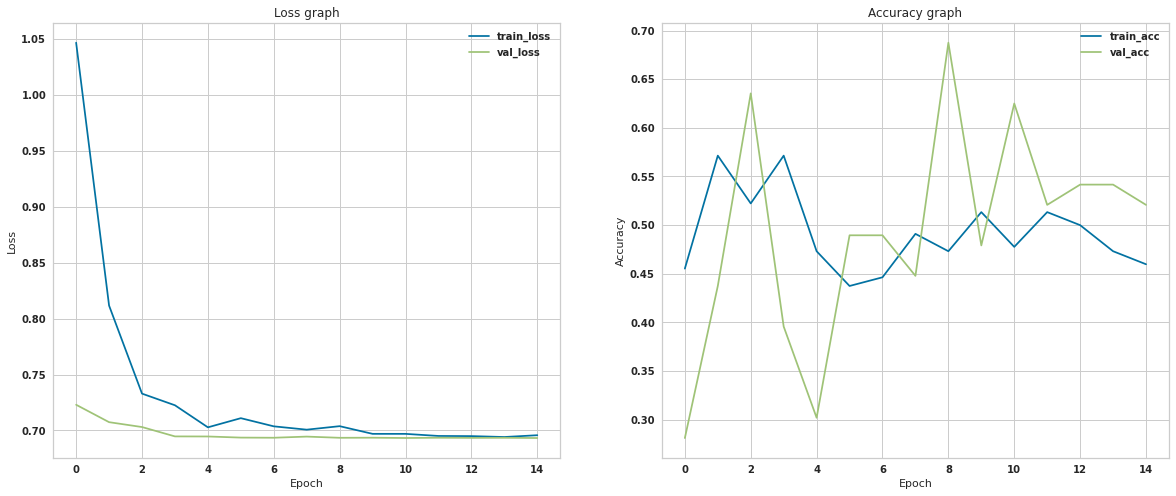

In [ ]:
plot_model_performance (model_history)

In [ ]:
output_layer = model.predict(x=X_test, verbose=0)
np.round(output_layer)

y_pred = np.argmax(output_layer, axis=-1)

In [ ]:
import matplotlib.pyplot as plt

font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 20}
plt.rc('font', **font)

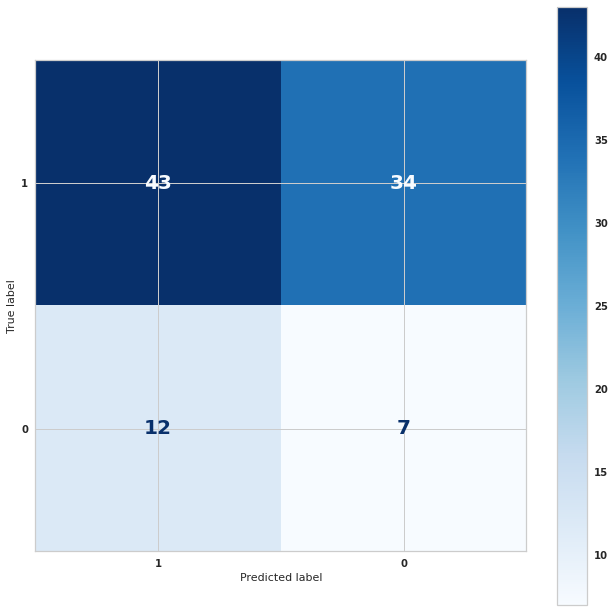

              precision    recall  f1-score   support

           1       0.78      0.56      0.65        77
           0       0.17      0.37      0.23        19

    accuracy                           0.52        96
   macro avg       0.48      0.46      0.44        96
weighted avg       0.66      0.52      0.57        96



In [ ]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(11, 11))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '0'], )

disp.plot(cmap =plt.cm.Blues, ax = ax)
plt.show()

print(classification_report(y_test, y_pred, target_names=['1', '0']))

## **6.12 Trying more CNN models**

In [ ]:
"model = Sequential()

model.add(Conv1D(filters=120, kernel_size=3, activation='relu', input_shape=(80,5)))
model.add(MaxPooling1D())

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D()

model.add(Flatten())

model.add(Dense(units=2, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 78, 120)           1920      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 120)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 64)            23104     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 2)                